# 🏗️Import Necessary Libraries

In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style='darkgrid')

2025-10-03 12:41:37.334428: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-03 12:41:37.556884: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-03 12:41:37.556933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-03 12:41:37.594096: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-03 12:41:37.669225: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)
    
    # Seed value for NumPy
    np.random.seed(seed)
    
    # Seed value for Python's random library
    random.seed(seed)
    
    # Force TensorFlow to use single thread
    # Multiple threads are a potential source of non-reproducible results.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Make sure that TensorFlow uses a deterministic operation wherever possible
    tf.compat.v1.set_random_seed(seed)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

seed_everything()

2025-10-03 12:41:41.713855: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-03 12:41:41.827284: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-03 12:41:41.827477: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# 🤙Create helper functions

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2025-10-03 12:41:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2025-10-03 12:41:42 (13.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# 📥Load and Transform Data

In [4]:
BATCH_SIZE = 8
TARGET_SIZE = (224, 224)

In [5]:
# Walk through each directory
dataset = "/home/pmd/Downloads/raabin_wbc/"
walk_through_dir(dataset)

There are 3 directories and 0 images in '/home/pmd/Downloads/raabin_wbc/'.
There are 2 directories and 0 images in '/home/pmd/Downloads/raabin_wbc/Test-B'.
There are 0 directories and 1971 images in '/home/pmd/Downloads/raabin_wbc/Test-B/Neutrophil'.
There are 0 directories and 148 images in '/home/pmd/Downloads/raabin_wbc/Test-B/Lymphocyte'.
There are 5 directories and 0 images in '/home/pmd/Downloads/raabin_wbc/Test-A'.
There are 0 directories and 89 images in '/home/pmd/Downloads/raabin_wbc/Test-A/Basophil'.
There are 0 directories and 234 images in '/home/pmd/Downloads/raabin_wbc/Test-A/Monocyte'.
There are 0 directories and 2660 images in '/home/pmd/Downloads/raabin_wbc/Test-A/Neutrophil'.
There are 0 directories and 322 images in '/home/pmd/Downloads/raabin_wbc/Test-A/Eosinophil'.
There are 0 directories and 1034 images in '/home/pmd/Downloads/raabin_wbc/Test-A/Lymphocyte'.
There are 5 directories and 0 images in '/home/pmd/Downloads/raabin_wbc/Train'.
There are 0 directories and

# 📅Placing data into a Dataframe
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The first column <b>filepaths</b> contains the file path location of each individual images. The second column <b>labels</b>, on the other hand, contains the class label of the corresponding image from the file path</p>

In [6]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

In [7]:
# Check for corrupted images within the dataset
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path("/home/pmd/Downloads/raabin_wbc/").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

/tmp/ipykernel_4419/609307592.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='rocket')


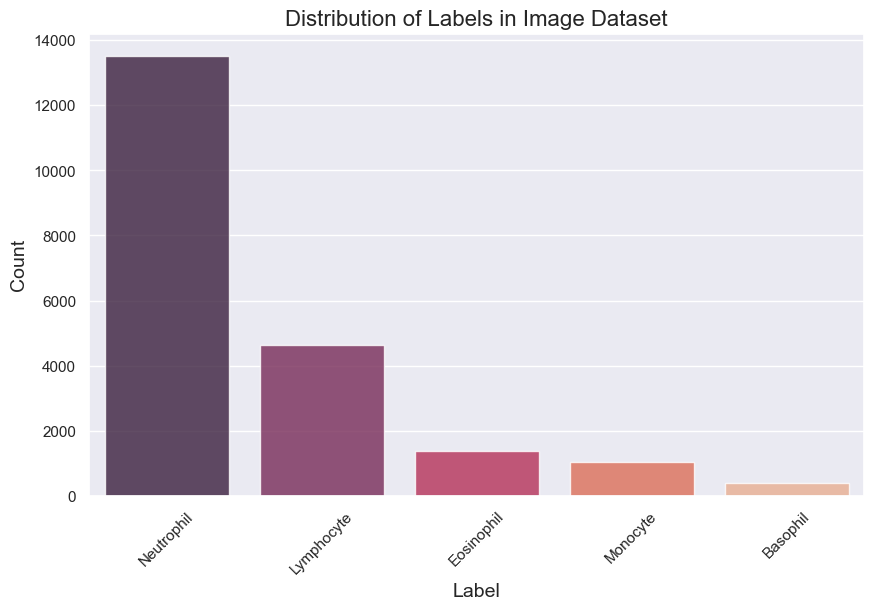

In [8]:
label_counts = image_df['Label'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='rocket')
plt.title('Distribution of Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45) 
plt.show()


# 🔭Visualizing images from the dataset

In [9]:
# import os
# import numpy as np
# import pandas as pd
# from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
# from tqdm import tqdm

# # Parameters
# SEED = 42
# image_size = (224, 224)
# augment_save_dir = '/home/pmd/Downloads/raabin_wbc/'  # create if not exists
# os.makedirs(augment_save_dir, exist_ok=True)

# # Target samples per class
# target_counts = {
#     # 'Neutrophil': 13000,
#     'Lymphocyte': 13000,
#     'Eosinophil': 13000,
#     'Monocyte': 13000,
#     'Basophil': 13000
# }

# # Augmentation generator
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     channel_shift_range=50.0,
#     fill_mode='nearest'
# )

# def augment_and_save(df, target_counts, save_dir, image_size=(224, 224)):
#     augmented_records = []

#     for target_class, target_count in target_counts.items():
#         class_df = df[df['labels'] == target_class]
#         current_count = len(class_df)
#         augment_count = target_count - current_count
#         print(f"[{target_class}] Current: {current_count}, Augmenting: {augment_count}")

#         if augment_count <= 0:
#             continue

#         # Load class images
#         images = []
#         for path in class_df['filepaths']:
#             img = load_img(path, target_size=image_size)
#             arr = img_to_array(img)
#             images.append(arr)
#         images = np.array(images)

#         # Generate and save augmented images
#         gen = datagen.flow(images, batch_size=1, seed=SEED)
#         for i in tqdm(range(augment_count), desc=f"Augmenting {target_class}"):
#             aug_img = gen.next()[0].astype(np.uint8)
#             save_name = f"aug_{target_class}_{i:04d}.jpg"
#             save_path = os.path.join(save_dir, save_name)
#             array_to_img(aug_img).save(save_path)
#             augmented_records.append((save_path, target_class))

#     return pd.DataFrame(augmented_records, columns=['filepaths', 'labels'])

# # Your original df (e.g., built from train/test folders)
# # df = pd.DataFrame({'filepaths': [...], 'labels': [...]})

# # Run the augmentation and save new images
# augmented_df = augment_and_save(df, target_counts, augment_save_dir, image_size=image_size)

# # Combine with original
# combined_df = pd.concat([df, augmented_df], ignore_index=True)

# # Optional: Shuffle and save
# combined_df = combined_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
# combined_df.to_csv('/home/pmd/Downloads/raabin_wbc/augmented_dataset_cbam.csv', index=False)

# print("✅ Augmentation complete. Final dataset saved as 'augmented_dataset.csv'")


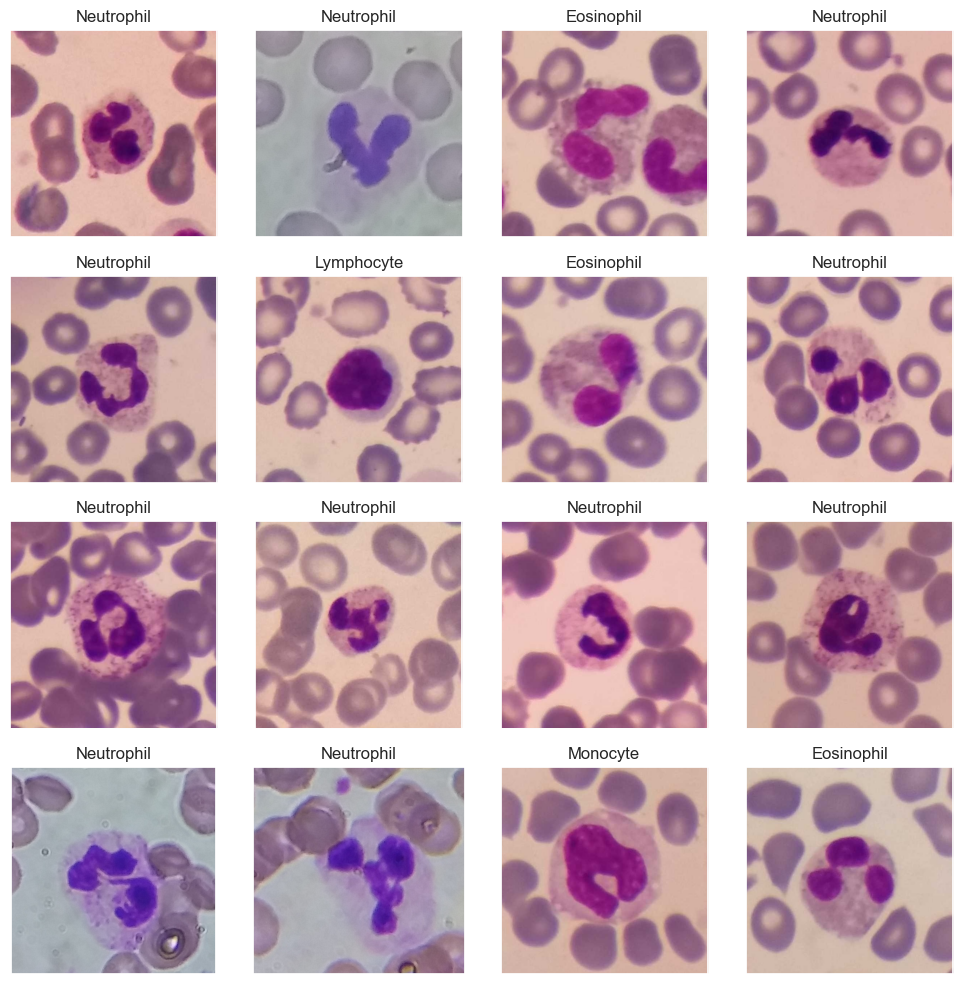

In [10]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# 🧮Computing Error Rate Analysis

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The code below is used for error level analysis (ELA) of images in the context of a pest image classification task.</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The compute_ela_cv() function takes an image path and a quality parameter, compresses the image using JPEG compression at the given quality, and computes the absolute difference between the compressed and original images. The difference is multiplied by a scale factor and returned as an ELA image.</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The convert_to_ela_image() function takes an image path and a quality parameter, compresses the image using JPEG compression at the given quality, computes the absolute difference between the compressed and original images, and returns an ELA image. The ELA image is computed using the difference in pixel values between the original and compressed images, and is normalized to enhance the differences.</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The random_sample() function takes a directory path and an optional file extension, and returns a random file path from that directory with the specified extension (if provided).</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">Finally, the code generates a set of ELA images using the compute_ela_cv() function for a randomly selected image from the test dataset of pest images. The ELA images are generated with decreasing quality levels, resulting in increasing levels of compression and thus increasing levels of error. The resulting images are plotted using matplotlib.</p>

In [11]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

In [12]:
# # View random sample from the dataset
# p = random_sample('/home/pmd/Downloads/raabin_wbc/Neutrophil')
# orig = cv2.imread(p)
# orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
# init_val = 100
# columns = 3
# rows = 3

# fig=plt.figure(figsize=(15, 10))
# for i in range(1, columns*rows +1):
#     quality=init_val - (i-1) * 8
#     img = compute_ela_cv(path=p, quality=quality)
#     if i == 1:
#         img = orig.copy()
#     ax = fig.add_subplot(rows, columns, i) 
#     ax.title.set_text(f'q: {quality}')
#     plt.imshow(img)
# plt.show()

# 📝Data Preprocessing
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).</p>

In [13]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [14]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
)

In [15]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 13422 validated image filenames belonging to 5 classes.
Found 3355 validated image filenames belonging to 5 classes.
Found 4195 validated image filenames belonging to 5 classes.


In [16]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

2025-10-03 12:41:47.619457: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-03 12:41:47.619685: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-03 12:41:47.619764: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Training the model

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers

# -------------------------
# Load Pretrained Backbone
# -------------------------
pretrained_model = tf.keras.applications.efficientnet_v2.EfficientNetV2L(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

# Phase 1: freeze backbone
pretrained_model.trainable = False

# -------------------------
# Build Classification Head
# -------------------------
inputs = pretrained_model.input
x = augment(inputs)   # your augmentation pipeline

x = pretrained_model.output
x = Dense(128, activation='relu', 
          kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu', 
          kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.45)(x)
outputs = Dense(5, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# -------------------------
# Callbacks
# -------------------------
checkpoint_path = "mb_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

early_stopping = EarlyStopping(monitor="val_loss",
                               patience=5,
                               restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor="val_loss",
                                 factor=0.5,
                                 patience=3,
                                 min_lr=1e-7)

# -------------------------
# Phase 1: Train classifier head
# -------------------------
model.compile(
    optimizer=Adam(1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

history_head = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=15,
    callbacks=[early_stopping, checkpoint_callback]
)

# -------------------------
# Phase 2: Fine-tuning
# -------------------------
# Unfreeze the last 50 layers of EfficientNetV2L
pretrained_model.trainable = True
for layer in pretrained_model.layers[:-50]:
    layer.trainable = False

# Re-compile with lower learning rate
model.compile(
    optimizer=Adam(1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

history_finetune = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=30,
    callbacks=[early_stopping, checkpoint_callback, lr_scheduler]
)


Epoch 1/15


2025-10-03 12:42:05.309613: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-10-03 12:42:09.839401: I external/local_xla/xla/service/service.cc:168] XLA service 0x7b9864ab4240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-03 12:42:09.839418: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-10-03 12:42:09.848197: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759475529.919702    4946 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


420/420 [==============================] - 200s 437ms/step - loss: 1.3539 - accuracy: 0.5952 - val_loss: 1.0232 - val_accuracy: 0.7183
Epoch 2/15
420/420 [==============================] - 177s 421ms/step - loss: 1.1361 - accuracy: 0.6862 - val_loss: 0.9762 - val_accuracy: 0.7782
Epoch 3/15
420/420 [==============================] - 176s 419ms/step - loss: 1.0730 - accuracy: 0.7155 - val_loss: 0.9477 - val_accuracy: 0.7636
Epoch 4/15
420/420 [==============================] - 177s 421ms/step - loss: 1.0159 - accuracy: 0.7430 - val_loss: 0.8922 - val_accuracy: 0.8048
Epoch 5/15
420/420 [==============================] - 177s 422ms/step - loss: 0.9846 - accuracy: 0.7534 - val_loss: 0.8903 - val_accuracy: 0.8235
Epoch 6/15
420/420 [==============================] - 176s 420ms/step - loss: 0.9613 - accuracy: 0.7668 - val_loss: 0.8399 - val_accuracy: 0.8209
Epoch 7/15
420/420 [==============================] - 176s 419ms/step - loss: 0.9389 - accuracy: 0.7744 - val_loss: 0.8319 - val_accura

2025-10-03 13:26:32.530800: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


420/420 [==============================] - 215s 478ms/step - loss: 0.7935 - accuracy: 0.8422 - val_loss: 0.6119 - val_accuracy: 0.9228 - lr: 1.0000e-05
Epoch 2/30
420/420 [==============================] - 198s 471ms/step - loss: 0.6963 - accuracy: 0.8841 - val_loss: 0.5644 - val_accuracy: 0.9463 - lr: 1.0000e-05
Epoch 3/30
420/420 [==============================] - 198s 470ms/step - loss: 0.6463 - accuracy: 0.9062 - val_loss: 0.5338 - val_accuracy: 0.9627 - lr: 1.0000e-05
Epoch 4/30
420/420 [==============================] - 198s 471ms/step - loss: 0.6104 - accuracy: 0.9244 - val_loss: 0.5105 - val_accuracy: 0.9720 - lr: 1.0000e-05
Epoch 5/30
420/420 [==============================] - 198s 471ms/step - loss: 0.5909 - accuracy: 0.9321 - val_loss: 0.4989 - val_accuracy: 0.9744 - lr: 1.0000e-05
Epoch 6/30
420/420 [==============================] - 198s 471ms/step - loss: 0.5721 - accuracy: 0.9431 - val_loss: 0.4837 - val_accuracy: 0.9770 - lr: 1.0000e-05
Epoch 7/30
420/420 [=============

# ✔️Model Evaluation
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The test dataset will be used to evaluate the performance of the model.One of the metrics that will be tested would be accuracy which measures the fraction of predictions the model got right. Other metrics are as follows:   </p>

<h3>Precision(P):</h3> 
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The fraction of true positives (TP, correct predictions) from the total amount of relevant results, i.e., the sum of TP and false positives (FP). For multi-class classification problems, P is averaged among the classes. The following is the formula for precision.</p>

<h4>
  <center>
    <span style="font-size: 1.5em">
      $P = \frac{TP}{TP+FP}$
    </span>
  </center>
</h4>


<h3>Recall(R): </h3> 
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The fraction of TP from the total amount of TP and false negatives (FN). For multi-class classification problems, R gets averaged among all the classes. The following is the formula for recall.</p>

<h4>
  <center>
    <span style="font-size: 1.5em">
      $R = \frac{TP}{TP+FN}$
    </span>
  </center>
</h4>


<h3>F1 score(F1): </h3>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The harmonic mean of precision and recall. For multi-class classification problems, F1 gets averaged among all the classes. The following is the formula for F1 score.</p>

<h4>
  <center>
    <span style="font-size: 1.5em">
      $F1 = 2 \times \frac{TP \times FP}{TP + FP}$
    </span>
  </center>
</h4>





In [22]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.45621
Test Accuracy: 98.78%


# 📉Visualizing loss curves

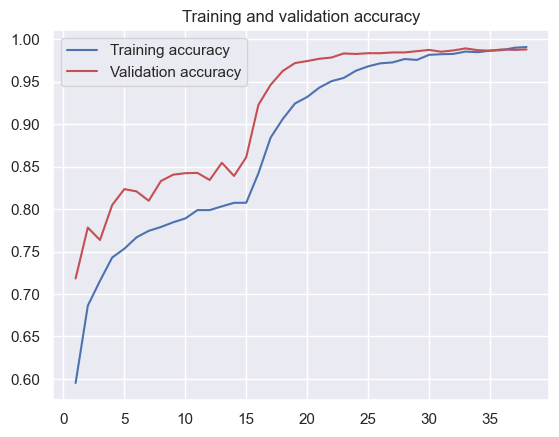

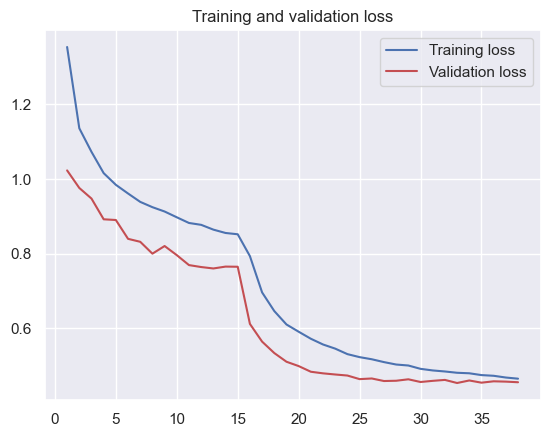

In [23]:
# Combine metrics from both training phases
accuracy = history_head.history['accuracy'] + history_finetune.history['accuracy']
val_accuracy = history_head.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss = history_head.history['loss'] + history_finetune.history['loss']
val_loss = history_head.history['val_loss'] + history_finetune.history['val_loss']

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# 🔮Making predictions on the Test Data

In [24]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

132/132 [==============================] - 45s 323ms/step
The first 5 predictions: ['Lymphocyte', 'Neutrophil', 'Neutrophil', 'Neutrophil', 'Eosinophil']


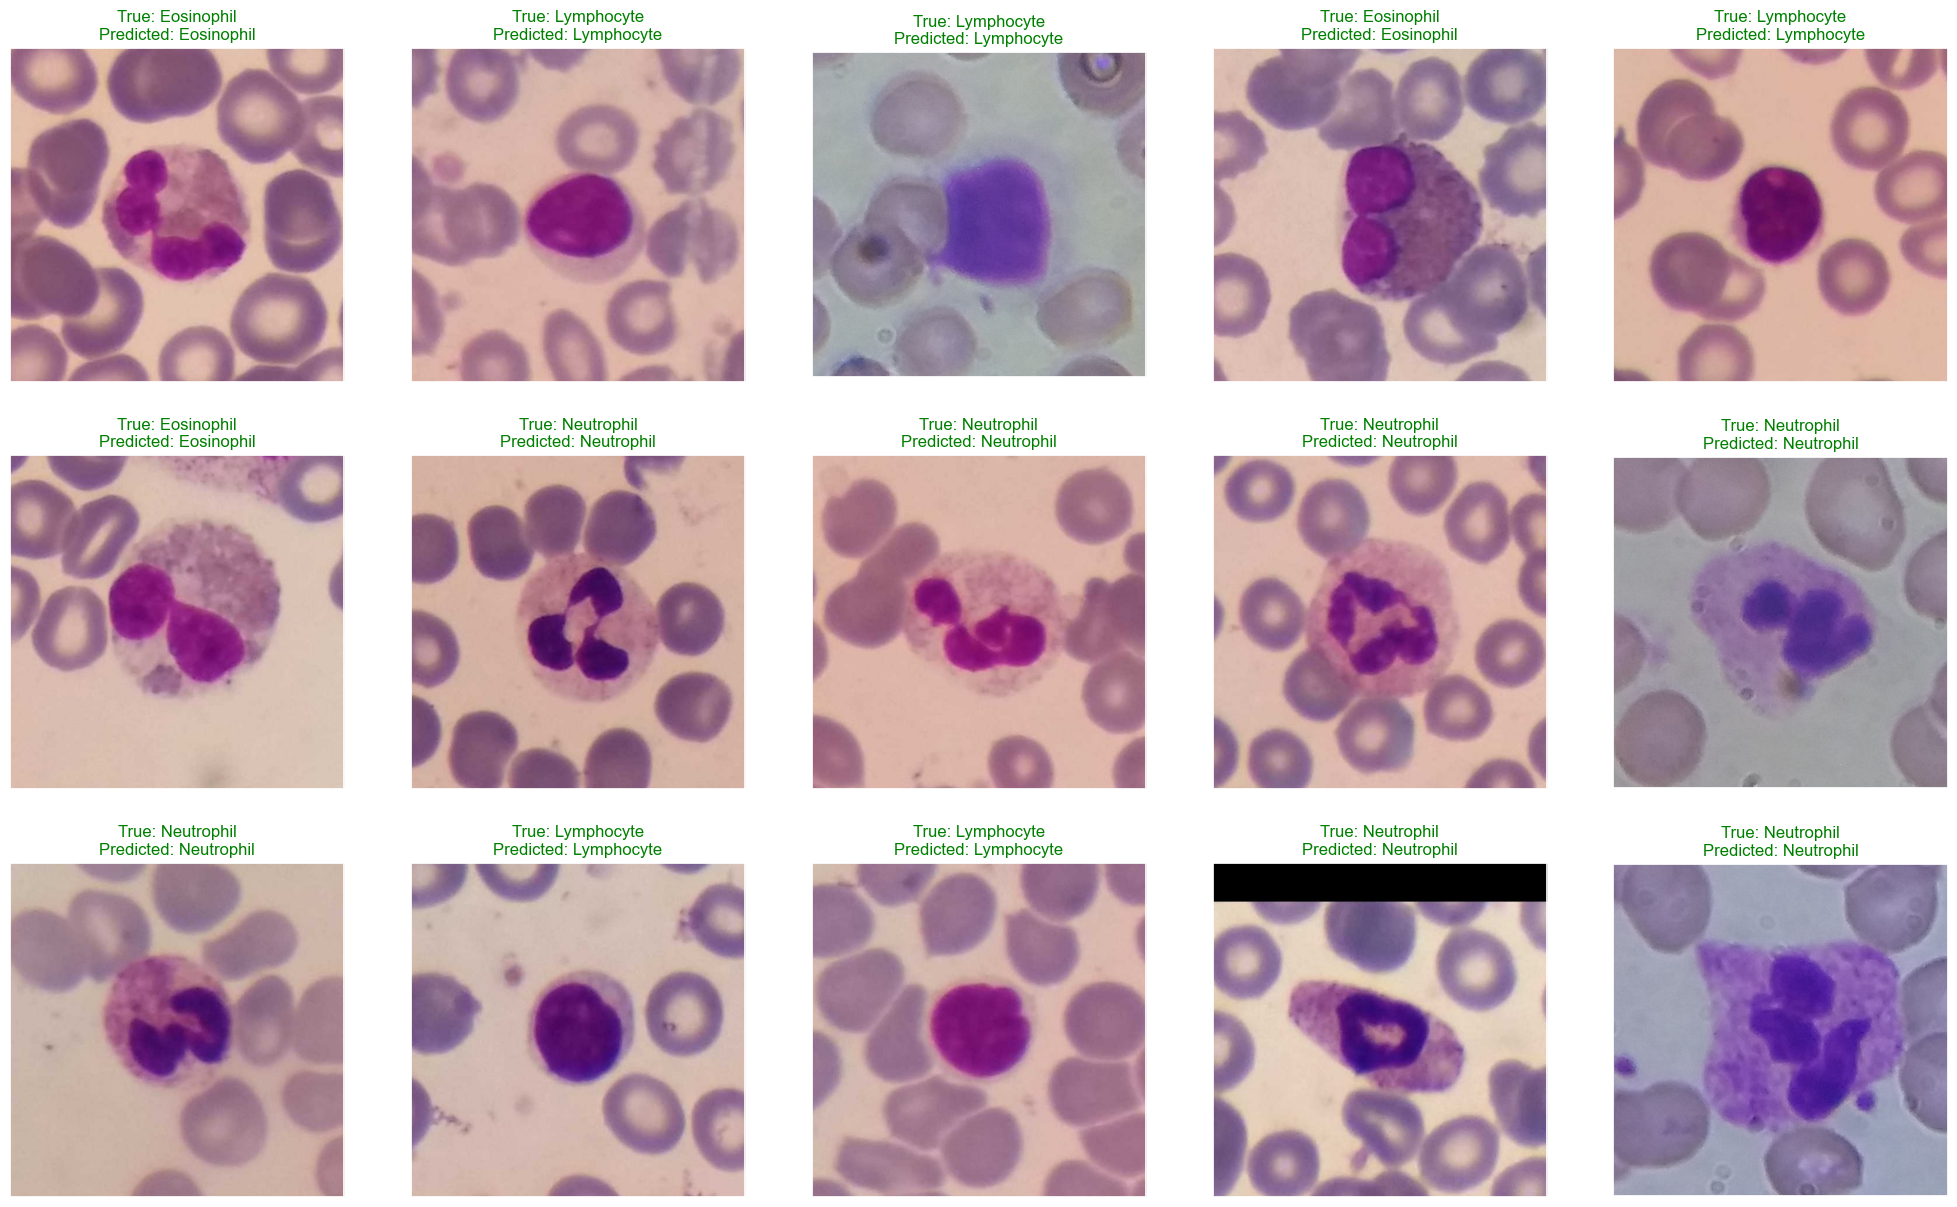

<Figure size 640x480 with 0 Axes>

In [25]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [26]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    Basophil       1.00      0.99      0.99        94
  Eosinophil       0.95      0.97      0.96       295
  Lymphocyte       0.99      0.99      0.99       911
    Monocyte       0.96      0.93      0.95       198
  Neutrophil       0.99      0.99      0.99      2697

    accuracy                           0.99      4195
   macro avg       0.98      0.97      0.98      4195
weighted avg       0.99      0.99      0.99      4195



In [27]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score      support
Basophil       1.000000  0.989362  0.994652    94.000000
Eosinophil     0.953488  0.972881  0.963087   295.000000
Lymphocyte     0.985761  0.987925  0.986842   911.000000
Monocyte       0.963351  0.929293  0.946015   198.000000
Neutrophil     0.993697  0.993697  0.993697  2697.000000
accuracy       0.987843  0.987843  0.987843     0.987843
macro avg      0.979259  0.974632  0.976859  4195.000000
weighted avg   0.987855  0.987843  0.987827  4195.000000

In [28]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """  
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


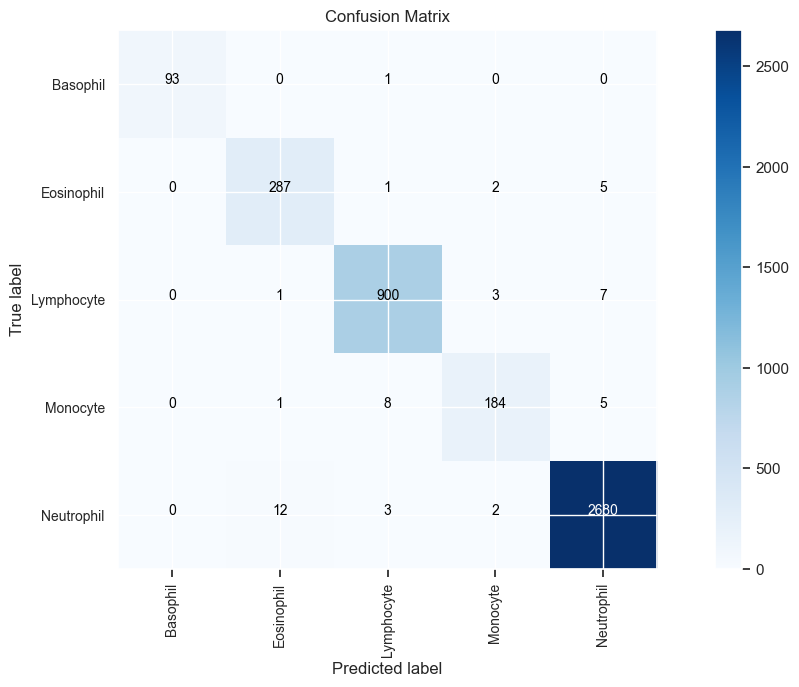

In [29]:
make_confusion_matrix(y_test, pred, list(labels.values()))

# Grad-Cam Visualization


In [30]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.9):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    

preprocess_input = tf.keras.applications.efficientnet.preprocess_input
decode_predictions = tf.keras.applications.efficientnet.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

/tmp/ipykernel_4419/317114919.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


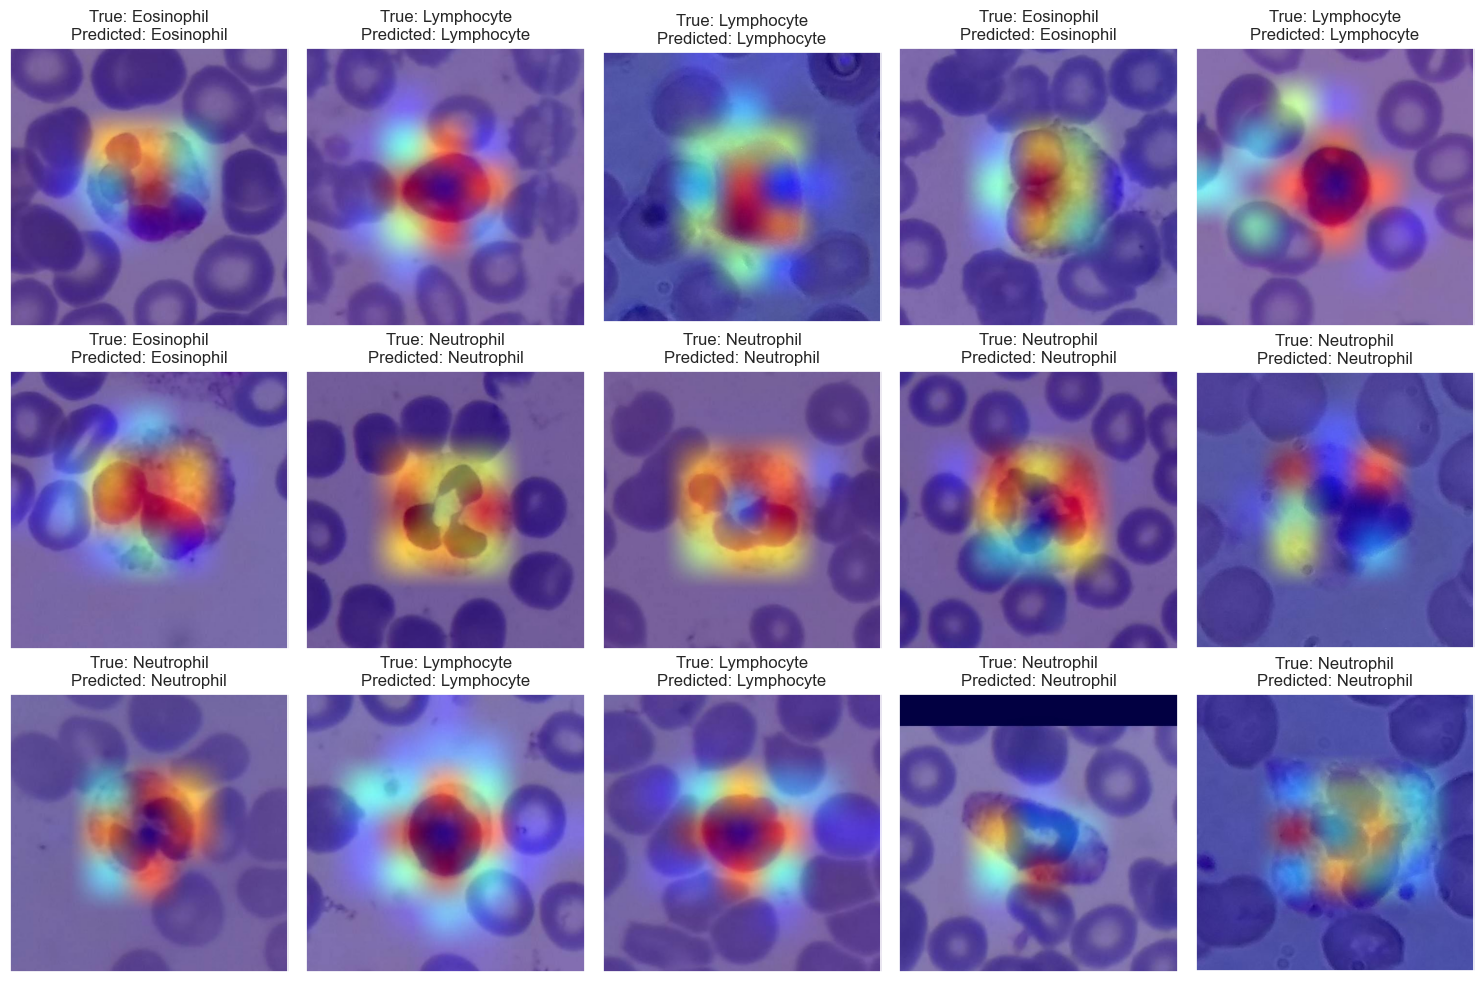

In [31]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()

132/132 [==============================] - 42s 322ms/step


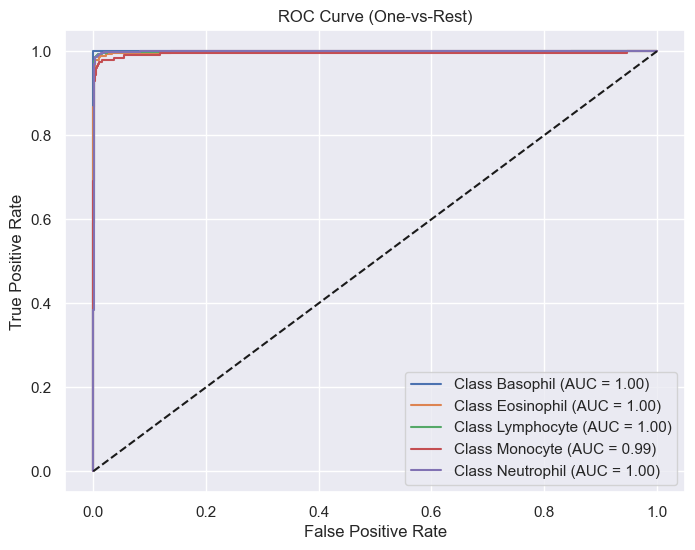

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# Ground truth labels (convert to numeric if they are categorical)
y_true = np.array(y_test)

# If y_test is categorical strings → convert to numbers
# Example: {"cat":0, "dog":1, ...}
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_true = le.fit_transform(y_true)

# Binarize labels for multiclass ROC
n_classes = len(np.unique(y_true))
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# Predicted probabilities (not class labels!)
# If you only have predicted labels (pred), get probabilities from model:
# pred_proba = model.predict(test_images)
pred_proba = model.predict(test_images)   # shape: (n_samples, n_classes)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})")

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.show()


/tmp/ipykernel_4419/922654454.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")
  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 60ms/step


  1%|          | 10/1000 [00:00<00:14, 69.20it/s]

1/1 [==============================] - 0s 60ms/step


  2%|▏         | 20/1000 [00:00<00:14, 68.27it/s]

1/1 [==============================] - 0s 55ms/step


  3%|▎         | 30/1000 [00:00<00:13, 69.66it/s]

1/1 [==============================] - 0s 55ms/step


  4%|▍         | 40/1000 [00:00<00:13, 70.96it/s]

1/1 [==============================] - 0s 55ms/step


  5%|▌         | 50/1000 [00:00<00:13, 68.86it/s]

1/1 [==============================] - 0s 55ms/step


  6%|▌         | 60/1000 [00:00<00:13, 69.74it/s]

1/1 [==============================] - 0s 56ms/step


  7%|▋         | 70/1000 [00:01<00:13, 70.54it/s]

1/1 [==============================] - 0s 57ms/step


  8%|▊         | 80/1000 [00:01<00:13, 70.37it/s]

1/1 [==============================] - 0s 56ms/step


  9%|▉         | 90/1000 [00:01<00:13, 69.98it/s]

1/1 [==============================] - 0s 55ms/step


 10%|█         | 100/1000 [00:01<00:12, 69.94it/s]

1/1 [==============================] - 0s 54ms/step


 11%|█         | 110/1000 [00:01<00:12, 70.04it/s]

1/1 [==============================] - 0s 56ms/step


 12%|█▏        | 120/1000 [00:01<00:12, 70.48it/s]

1/1 [==============================] - 0s 57ms/step


 13%|█▎        | 130/1000 [00:01<00:12, 69.84it/s]

1/1 [==============================] - 0s 55ms/step


 14%|█▍        | 140/1000 [00:02<00:12, 69.42it/s]

1/1 [==============================] - 0s 56ms/step


 15%|█▌        | 150/1000 [00:02<00:12, 69.31it/s]

1/1 [==============================] - 0s 55ms/step


 16%|█▌        | 160/1000 [00:02<00:11, 70.02it/s]

1/1 [==============================] - 0s 54ms/step


 17%|█▋        | 170/1000 [00:02<00:11, 70.56it/s]

1/1 [==============================] - 0s 55ms/step


 18%|█▊        | 180/1000 [00:02<00:11, 69.88it/s]

1/1 [==============================] - 0s 56ms/step


 19%|█▉        | 190/1000 [00:02<00:11, 70.20it/s]

1/1 [==============================] - 0s 57ms/step


 20%|██        | 200/1000 [00:02<00:11, 69.82it/s]

1/1 [==============================] - 0s 61ms/step


 21%|██        | 210/1000 [00:03<00:11, 67.84it/s]

1/1 [==============================] - 0s 58ms/step


 22%|██▏       | 220/1000 [00:03<00:11, 66.32it/s]

1/1 [==============================] - 0s 56ms/step


 23%|██▎       | 230/1000 [00:03<00:11, 67.02it/s]

1/1 [==============================] - 0s 56ms/step


 24%|██▍       | 240/1000 [00:03<00:11, 67.90it/s]

1/1 [==============================] - 0s 55ms/step


 25%|██▌       | 250/1000 [00:03<00:10, 68.46it/s]

1/1 [==============================] - 0s 56ms/step


 26%|██▌       | 260/1000 [00:03<00:10, 68.79it/s]

1/1 [==============================] - 0s 56ms/step


 27%|██▋       | 270/1000 [00:03<00:10, 67.90it/s]

1/1 [==============================] - 0s 55ms/step


 28%|██▊       | 280/1000 [00:04<00:10, 68.51it/s]

1/1 [==============================] - 0s 60ms/step


 29%|██▉       | 290/1000 [00:04<00:10, 68.23it/s]

1/1 [==============================] - 0s 57ms/step


 30%|███       | 300/1000 [00:04<00:10, 66.97it/s]

1/1 [==============================] - 0s 58ms/step


 31%|███       | 310/1000 [00:04<00:10, 67.09it/s]

1/1 [==============================] - 0s 57ms/step


 32%|███▏      | 320/1000 [00:04<00:10, 67.95it/s]

1/1 [==============================] - 0s 55ms/step


 33%|███▎      | 330/1000 [00:04<00:09, 68.70it/s]

1/1 [==============================] - 0s 58ms/step


 34%|███▍      | 340/1000 [00:04<00:09, 68.65it/s]

1/1 [==============================] - 0s 55ms/step


 35%|███▌      | 350/1000 [00:05<00:09, 69.14it/s]

1/1 [==============================] - 0s 56ms/step


 36%|███▌      | 360/1000 [00:05<00:09, 68.64it/s]

1/1 [==============================] - 0s 55ms/step


 37%|███▋      | 370/1000 [00:05<00:09, 68.71it/s]

1/1 [==============================] - 0s 55ms/step


 38%|███▊      | 380/1000 [00:05<00:09, 68.36it/s]

1/1 [==============================] - 0s 56ms/step


 39%|███▉      | 390/1000 [00:05<00:08, 68.58it/s]

1/1 [==============================] - 0s 56ms/step


 40%|████      | 400/1000 [00:05<00:08, 68.99it/s]

1/1 [==============================] - 0s 56ms/step


 41%|████      | 410/1000 [00:05<00:08, 68.93it/s]

1/1 [==============================] - 0s 56ms/step


 42%|████▏     | 420/1000 [00:06<00:08, 69.36it/s]

1/1 [==============================] - 0s 55ms/step


 43%|████▎     | 430/1000 [00:06<00:08, 69.68it/s]

1/1 [==============================] - 0s 55ms/step


 44%|████▍     | 440/1000 [00:06<00:07, 70.33it/s]

1/1 [==============================] - 0s 56ms/step


 45%|████▌     | 450/1000 [00:06<00:07, 68.91it/s]

1/1 [==============================] - 0s 55ms/step


 46%|████▌     | 460/1000 [00:06<00:07, 69.87it/s]

1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 470/1000 [00:06<00:07, 69.48it/s]

1/1 [==============================] - 0s 56ms/step


 48%|████▊     | 480/1000 [00:06<00:07, 69.84it/s]

1/1 [==============================] - 0s 55ms/step


 49%|████▉     | 490/1000 [00:07<00:07, 70.39it/s]

1/1 [==============================] - 0s 55ms/step


 50%|█████     | 500/1000 [00:07<00:07, 70.94it/s]

1/1 [==============================] - 0s 57ms/step


 51%|█████     | 510/1000 [00:07<00:06, 70.99it/s]

1/1 [==============================] - 0s 56ms/step


 52%|█████▏    | 520/1000 [00:07<00:06, 70.44it/s]

1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 530/1000 [00:07<00:06, 68.64it/s]

1/1 [==============================] - 0s 56ms/step


 54%|█████▍    | 540/1000 [00:07<00:06, 68.33it/s]

1/1 [==============================] - 0s 56ms/step


 55%|█████▌    | 550/1000 [00:07<00:06, 68.20it/s]

1/1 [==============================] - 0s 54ms/step


 56%|█████▌    | 560/1000 [00:08<00:06, 68.13it/s]

1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 570/1000 [00:08<00:06, 68.82it/s]

1/1 [==============================] - 0s 58ms/step


 58%|█████▊    | 580/1000 [00:08<00:06, 69.25it/s]

1/1 [==============================] - 0s 57ms/step


 59%|█████▉    | 590/1000 [00:08<00:05, 69.05it/s]

1/1 [==============================] - 0s 58ms/step


 60%|██████    | 600/1000 [00:08<00:06, 66.33it/s]

1/1 [==============================] - 0s 55ms/step


 61%|██████    | 610/1000 [00:08<00:05, 67.78it/s]

1/1 [==============================] - 0s 60ms/step


 62%|██████▏   | 620/1000 [00:08<00:05, 67.92it/s]

1/1 [==============================] - 0s 61ms/step


 63%|██████▎   | 630/1000 [00:09<00:05, 65.74it/s]

1/1 [==============================] - 0s 61ms/step


 64%|██████▍   | 640/1000 [00:09<00:05, 64.96it/s]

1/1 [==============================] - 0s 58ms/step


 65%|██████▌   | 650/1000 [00:09<00:05, 64.56it/s]

1/1 [==============================] - 0s 62ms/step


 66%|██████▌   | 660/1000 [00:09<00:05, 62.23it/s]

1/1 [==============================] - 0s 62ms/step


 67%|██████▋   | 670/1000 [00:09<00:05, 62.11it/s]

1/1 [==============================] - 0s 59ms/step


 68%|██████▊   | 680/1000 [00:09<00:05, 61.66it/s]

1/1 [==============================] - 0s 57ms/step


 69%|██████▉   | 690/1000 [00:10<00:04, 63.32it/s]

1/1 [==============================] - 0s 56ms/step


 70%|███████   | 700/1000 [00:10<00:04, 63.93it/s]

1/1 [==============================] - 0s 55ms/step


 71%|███████   | 710/1000 [00:10<00:04, 65.72it/s]

1/1 [==============================] - 0s 63ms/step


 72%|███████▏  | 720/1000 [00:10<00:04, 65.72it/s]

1/1 [==============================] - 0s 58ms/step


 73%|███████▎  | 730/1000 [00:10<00:04, 66.62it/s]

1/1 [==============================] - 0s 55ms/step


 74%|███████▍  | 740/1000 [00:10<00:03, 67.50it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▌  | 750/1000 [00:10<00:03, 68.70it/s]

1/1 [==============================] - 0s 57ms/step


 76%|███████▌  | 760/1000 [00:11<00:03, 68.69it/s]

1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 770/1000 [00:11<00:03, 68.66it/s]

1/1 [==============================] - 0s 57ms/step


 78%|███████▊  | 780/1000 [00:11<00:03, 68.13it/s]

1/1 [==============================] - 0s 54ms/step


 79%|███████▉  | 790/1000 [00:11<00:03, 67.85it/s]

1/1 [==============================] - 0s 55ms/step


 80%|████████  | 800/1000 [00:11<00:02, 68.80it/s]

1/1 [==============================] - 0s 55ms/step


 81%|████████  | 810/1000 [00:11<00:02, 69.23it/s]

1/1 [==============================] - 0s 54ms/step


 82%|████████▏ | 820/1000 [00:12<00:02, 69.85it/s]

1/1 [==============================] - 0s 54ms/step


 83%|████████▎ | 830/1000 [00:12<00:02, 67.93it/s]

1/1 [==============================] - 0s 57ms/step


 84%|████████▍ | 840/1000 [00:12<00:02, 68.11it/s]

1/1 [==============================] - 0s 59ms/step


 85%|████████▌ | 850/1000 [00:12<00:02, 66.99it/s]

1/1 [==============================] - 0s 58ms/step


 86%|████████▌ | 860/1000 [00:12<00:02, 66.87it/s]

1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 870/1000 [00:12<00:01, 66.94it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 880/1000 [00:12<00:01, 68.04it/s]

1/1 [==============================] - 0s 56ms/step


 89%|████████▉ | 890/1000 [00:13<00:01, 67.80it/s]

1/1 [==============================] - 0s 58ms/step


 90%|█████████ | 900/1000 [00:13<00:01, 67.04it/s]

1/1 [==============================] - 0s 56ms/step


 91%|█████████ | 910/1000 [00:13<00:01, 66.65it/s]

1/1 [==============================] - 0s 59ms/step


 92%|█████████▏| 920/1000 [00:13<00:01, 67.23it/s]

1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 930/1000 [00:13<00:01, 66.75it/s]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 940/1000 [00:13<00:00, 67.55it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▌| 950/1000 [00:13<00:00, 69.19it/s]

1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 960/1000 [00:14<00:00, 69.45it/s]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 970/1000 [00:14<00:00, 68.99it/s]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 980/1000 [00:14<00:00, 70.46it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 990/1000 [00:14<00:00, 69.31it/s]

1/1 [==============================] - 0s 61ms/step


100%|██████████| 1000/1000 [00:14<00:00, 68.18it/s]
/tmp/ipykernel_4419/922654454.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")
  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 59ms/step


  1%|          | 10/1000 [00:00<00:14, 68.25it/s]

1/1 [==============================] - 0s 59ms/step


  2%|▏         | 20/1000 [00:00<00:14, 68.07it/s]

1/1 [==============================] - 0s 56ms/step


  3%|▎         | 30/1000 [00:00<00:14, 68.50it/s]

1/1 [==============================] - 0s 54ms/step


  4%|▍         | 40/1000 [00:00<00:14, 67.92it/s]

1/1 [==============================] - 0s 54ms/step


  5%|▌         | 50/1000 [00:00<00:13, 70.81it/s]

1/1 [==============================] - 0s 58ms/step


  6%|▌         | 60/1000 [00:00<00:13, 71.74it/s]

1/1 [==============================] - 0s 55ms/step


  7%|▋         | 70/1000 [00:00<00:13, 71.47it/s]

1/1 [==============================] - 0s 58ms/step


  8%|▊         | 80/1000 [00:01<00:13, 70.67it/s]

1/1 [==============================] - 0s 54ms/step


  9%|▉         | 90/1000 [00:01<00:12, 70.89it/s]

1/1 [==============================] - 0s 55ms/step


 10%|█         | 100/1000 [00:01<00:12, 72.01it/s]

1/1 [==============================] - 0s 56ms/step


 11%|█         | 110/1000 [00:01<00:12, 69.82it/s]

1/1 [==============================] - 0s 55ms/step


 12%|█▏        | 120/1000 [00:01<00:12, 69.68it/s]

1/1 [==============================] - 0s 57ms/step


 13%|█▎        | 130/1000 [00:01<00:12, 70.87it/s]

1/1 [==============================] - 0s 55ms/step


 14%|█▍        | 140/1000 [00:01<00:11, 72.11it/s]

1/1 [==============================] - 0s 55ms/step


 15%|█▌        | 150/1000 [00:02<00:11, 72.49it/s]

1/1 [==============================] - 0s 59ms/step


 16%|█▌        | 160/1000 [00:02<00:11, 71.54it/s]

1/1 [==============================] - 0s 54ms/step


 17%|█▋        | 170/1000 [00:02<00:11, 72.21it/s]

1/1 [==============================] - 0s 53ms/step


 18%|█▊        | 180/1000 [00:02<00:11, 70.24it/s]

1/1 [==============================] - 0s 54ms/step


 19%|█▉        | 190/1000 [00:02<00:11, 71.61it/s]

1/1 [==============================] - 0s 54ms/step


 20%|██        | 200/1000 [00:02<00:10, 72.79it/s]

1/1 [==============================] - 0s 56ms/step


 21%|██        | 210/1000 [00:02<00:10, 72.73it/s]

1/1 [==============================] - 0s 54ms/step


 22%|██▏       | 220/1000 [00:03<00:10, 73.14it/s]

1/1 [==============================] - 0s 54ms/step


 23%|██▎       | 230/1000 [00:03<00:10, 73.59it/s]

1/1 [==============================] - 0s 54ms/step


 24%|██▍       | 240/1000 [00:03<00:10, 73.69it/s]

1/1 [==============================] - 0s 54ms/step


 25%|██▌       | 250/1000 [00:03<00:10, 72.59it/s]

1/1 [==============================] - 0s 54ms/step


 26%|██▌       | 260/1000 [00:03<00:10, 73.02it/s]

1/1 [==============================] - 0s 55ms/step


 27%|██▋       | 270/1000 [00:03<00:09, 73.16it/s]

1/1 [==============================] - 0s 56ms/step


 28%|██▊       | 280/1000 [00:03<00:09, 72.86it/s]

1/1 [==============================] - 0s 56ms/step


 29%|██▉       | 290/1000 [00:04<00:09, 73.67it/s]

1/1 [==============================] - 0s 56ms/step


 30%|███       | 300/1000 [00:04<00:09, 73.37it/s]

1/1 [==============================] - 0s 57ms/step


 31%|███       | 310/1000 [00:04<00:09, 72.98it/s]

1/1 [==============================] - 0s 55ms/step


 32%|███▏      | 320/1000 [00:04<00:09, 72.16it/s]

1/1 [==============================] - 0s 56ms/step


 33%|███▎      | 330/1000 [00:04<00:09, 72.28it/s]

1/1 [==============================] - 0s 56ms/step


 34%|███▍      | 340/1000 [00:04<00:09, 73.08it/s]

1/1 [==============================] - 0s 57ms/step


 35%|███▌      | 350/1000 [00:04<00:08, 73.29it/s]

1/1 [==============================] - 0s 56ms/step


 36%|███▌      | 360/1000 [00:05<00:08, 73.31it/s]

1/1 [==============================] - 0s 57ms/step


 37%|███▋      | 370/1000 [00:05<00:08, 72.48it/s]

1/1 [==============================] - 0s 58ms/step


 38%|███▊      | 380/1000 [00:05<00:08, 71.24it/s]

1/1 [==============================] - 0s 56ms/step


 39%|███▉      | 390/1000 [00:05<00:08, 70.84it/s]

1/1 [==============================] - 0s 56ms/step


 40%|████      | 400/1000 [00:05<00:08, 71.24it/s]

1/1 [==============================] - 0s 55ms/step


 41%|████      | 410/1000 [00:05<00:08, 71.93it/s]

1/1 [==============================] - 0s 60ms/step


 42%|████▏     | 420/1000 [00:05<00:08, 72.15it/s]

1/1 [==============================] - 0s 55ms/step


 43%|████▎     | 430/1000 [00:05<00:07, 72.79it/s]

1/1 [==============================] - 0s 60ms/step


 44%|████▍     | 440/1000 [00:06<00:07, 70.89it/s]

1/1 [==============================] - 0s 56ms/step


 45%|████▌     | 450/1000 [00:06<00:08, 66.81it/s]

1/1 [==============================] - 0s 58ms/step


 46%|████▌     | 460/1000 [00:06<00:08, 65.67it/s]

1/1 [==============================] - 0s 58ms/step


 47%|████▋     | 470/1000 [00:06<00:08, 65.58it/s]

1/1 [==============================] - 0s 58ms/step


 48%|████▊     | 480/1000 [00:06<00:07, 66.67it/s]

1/1 [==============================] - 0s 56ms/step


 49%|████▉     | 490/1000 [00:06<00:07, 67.91it/s]

1/1 [==============================] - 0s 57ms/step


 50%|█████     | 500/1000 [00:07<00:07, 68.48it/s]

1/1 [==============================] - 0s 57ms/step


 51%|█████     | 510/1000 [00:07<00:07, 69.37it/s]

1/1 [==============================] - 0s 57ms/step


 52%|█████▏    | 520/1000 [00:07<00:06, 68.69it/s]

1/1 [==============================] - 0s 60ms/step


 53%|█████▎    | 530/1000 [00:07<00:06, 67.57it/s]

1/1 [==============================] - 0s 59ms/step


 54%|█████▍    | 540/1000 [00:07<00:06, 67.06it/s]

1/1 [==============================] - 0s 55ms/step


 55%|█████▌    | 550/1000 [00:07<00:06, 66.60it/s]

1/1 [==============================] - 0s 60ms/step


 56%|█████▌    | 560/1000 [00:07<00:06, 66.33it/s]

1/1 [==============================] - 0s 68ms/step


 57%|█████▋    | 570/1000 [00:08<00:06, 62.17it/s]

1/1 [==============================] - 0s 61ms/step


 58%|█████▊    | 580/1000 [00:08<00:06, 61.68it/s]

1/1 [==============================] - 0s 61ms/step


 59%|█████▉    | 590/1000 [00:08<00:06, 60.10it/s]

1/1 [==============================] - 0s 59ms/step


 60%|██████    | 600/1000 [00:08<00:06, 62.45it/s]

1/1 [==============================] - 0s 57ms/step


 61%|██████    | 610/1000 [00:08<00:06, 63.73it/s]

1/1 [==============================] - 0s 57ms/step


 62%|██████▏   | 620/1000 [00:08<00:05, 65.05it/s]

1/1 [==============================] - 0s 61ms/step


 63%|██████▎   | 630/1000 [00:09<00:05, 63.80it/s]

1/1 [==============================] - 0s 59ms/step


 64%|██████▍   | 640/1000 [00:09<00:05, 63.59it/s]

1/1 [==============================] - 0s 60ms/step


 65%|██████▌   | 650/1000 [00:09<00:05, 63.69it/s]

1/1 [==============================] - 0s 59ms/step


 66%|██████▌   | 660/1000 [00:09<00:05, 61.45it/s]

1/1 [==============================] - 0s 63ms/step


 67%|██████▋   | 670/1000 [00:09<00:05, 61.36it/s]

1/1 [==============================] - 0s 57ms/step


 68%|██████▊   | 680/1000 [00:09<00:05, 63.78it/s]

1/1 [==============================] - 0s 54ms/step


 69%|██████▉   | 690/1000 [00:09<00:04, 66.39it/s]

1/1 [==============================] - 0s 55ms/step


 70%|███████   | 700/1000 [00:10<00:04, 68.70it/s]

1/1 [==============================] - 0s 60ms/step


 71%|███████   | 710/1000 [00:10<00:04, 68.66it/s]

1/1 [==============================] - 0s 61ms/step


 72%|███████▏  | 720/1000 [00:10<00:04, 67.10it/s]

1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 730/1000 [00:10<00:04, 65.66it/s]

1/1 [==============================] - 0s 57ms/step


 74%|███████▍  | 740/1000 [00:10<00:03, 65.43it/s]

1/1 [==============================] - 0s 61ms/step


 75%|███████▌  | 750/1000 [00:10<00:03, 63.90it/s]

1/1 [==============================] - 0s 61ms/step


 76%|███████▌  | 760/1000 [00:11<00:03, 64.26it/s]

1/1 [==============================] - 0s 59ms/step


 77%|███████▋  | 770/1000 [00:11<00:03, 64.77it/s]

1/1 [==============================] - 0s 61ms/step


 78%|███████▊  | 780/1000 [00:11<00:03, 65.35it/s]

1/1 [==============================] - 0s 57ms/step


 79%|███████▉  | 790/1000 [00:11<00:03, 65.90it/s]

1/1 [==============================] - 0s 62ms/step


 80%|████████  | 800/1000 [00:11<00:03, 63.32it/s]

1/1 [==============================] - 0s 57ms/step


 81%|████████  | 810/1000 [00:11<00:02, 64.22it/s]

1/1 [==============================] - 0s 57ms/step


 82%|████████▏ | 820/1000 [00:11<00:02, 64.99it/s]

1/1 [==============================] - 0s 56ms/step


 83%|████████▎ | 830/1000 [00:12<00:02, 65.86it/s]

1/1 [==============================] - 0s 58ms/step


 84%|████████▍ | 840/1000 [00:12<00:02, 67.42it/s]

1/1 [==============================] - 0s 54ms/step


 85%|████████▌ | 850/1000 [00:12<00:02, 69.35it/s]

1/1 [==============================] - 0s 57ms/step


 86%|████████▌ | 860/1000 [00:12<00:02, 67.83it/s]

1/1 [==============================] - 0s 56ms/step


 87%|████████▋ | 870/1000 [00:12<00:01, 68.68it/s]

1/1 [==============================] - 0s 55ms/step


 88%|████████▊ | 880/1000 [00:12<00:01, 70.09it/s]

1/1 [==============================] - 0s 55ms/step


 89%|████████▉ | 890/1000 [00:12<00:01, 71.18it/s]

1/1 [==============================] - 0s 56ms/step


 90%|█████████ | 900/1000 [00:13<00:01, 71.59it/s]

1/1 [==============================] - 0s 57ms/step


 91%|█████████ | 910/1000 [00:13<00:01, 72.05it/s]

1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 920/1000 [00:13<00:01, 72.25it/s]

1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 930/1000 [00:13<00:01, 69.62it/s]

1/1 [==============================] - 0s 61ms/step


 94%|█████████▍| 940/1000 [00:13<00:00, 67.97it/s]

1/1 [==============================] - 0s 58ms/step


 95%|█████████▌| 950/1000 [00:13<00:00, 67.31it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 960/1000 [00:13<00:00, 69.44it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 970/1000 [00:14<00:00, 71.40it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 980/1000 [00:14<00:00, 72.44it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▉| 990/1000 [00:14<00:00, 70.50it/s]

1/1 [==============================] - 0s 57ms/step


100%|██████████| 1000/1000 [00:14<00:00, 68.76it/s]
/tmp/ipykernel_4419/922654454.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")
  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 56ms/step


  1%|          | 10/1000 [00:00<00:13, 74.85it/s]

1/1 [==============================] - 0s 56ms/step


  2%|▏         | 20/1000 [00:00<00:13, 73.49it/s]

1/1 [==============================] - 0s 55ms/step


  3%|▎         | 30/1000 [00:00<00:13, 74.52it/s]

1/1 [==============================] - 0s 58ms/step


  4%|▍         | 40/1000 [00:00<00:13, 73.35it/s]

1/1 [==============================] - 0s 59ms/step


  5%|▌         | 50/1000 [00:00<00:13, 70.85it/s]

1/1 [==============================] - 0s 61ms/step


  6%|▌         | 60/1000 [00:00<00:14, 66.68it/s]

1/1 [==============================] - 0s 60ms/step


  7%|▋         | 70/1000 [00:01<00:14, 66.25it/s]

1/1 [==============================] - 0s 58ms/step


  8%|▊         | 80/1000 [00:01<00:13, 66.80it/s]

1/1 [==============================] - 0s 54ms/step


  9%|▉         | 90/1000 [00:01<00:13, 68.77it/s]

1/1 [==============================] - 0s 55ms/step


 10%|█         | 100/1000 [00:01<00:12, 70.51it/s]

1/1 [==============================] - 0s 57ms/step


 11%|█         | 110/1000 [00:01<00:12, 69.82it/s]

1/1 [==============================] - 0s 57ms/step


 12%|█▏        | 120/1000 [00:01<00:13, 65.84it/s]

1/1 [==============================] - 0s 56ms/step


 13%|█▎        | 130/1000 [00:01<00:13, 66.15it/s]

1/1 [==============================] - 0s 56ms/step


 14%|█▍        | 140/1000 [00:02<00:12, 66.88it/s]

1/1 [==============================] - 0s 56ms/step


 15%|█▌        | 150/1000 [00:02<00:12, 68.08it/s]

1/1 [==============================] - 0s 58ms/step


 16%|█▌        | 160/1000 [00:02<00:12, 68.81it/s]

1/1 [==============================] - 0s 57ms/step


 17%|█▋        | 170/1000 [00:02<00:11, 69.47it/s]

1/1 [==============================] - 0s 60ms/step


 18%|█▊        | 180/1000 [00:02<00:12, 67.28it/s]

1/1 [==============================] - 0s 58ms/step


 19%|█▉        | 190/1000 [00:02<00:11, 68.63it/s]

1/1 [==============================] - 0s 61ms/step


 20%|██        | 200/1000 [00:02<00:11, 69.29it/s]

1/1 [==============================] - 0s 59ms/step


 21%|██        | 210/1000 [00:03<00:11, 68.65it/s]

1/1 [==============================] - 0s 58ms/step


 22%|██▏       | 220/1000 [00:03<00:11, 68.88it/s]

1/1 [==============================] - 0s 58ms/step


 23%|██▎       | 230/1000 [00:03<00:11, 68.47it/s]

1/1 [==============================] - 0s 57ms/step


 24%|██▍       | 240/1000 [00:03<00:10, 69.49it/s]

1/1 [==============================] - 0s 56ms/step


 25%|██▌       | 250/1000 [00:03<00:10, 68.33it/s]

1/1 [==============================] - 0s 56ms/step


 26%|██▌       | 260/1000 [00:03<00:10, 68.19it/s]

1/1 [==============================] - 0s 56ms/step


 27%|██▋       | 270/1000 [00:03<00:10, 68.81it/s]

1/1 [==============================] - 0s 55ms/step


 28%|██▊       | 280/1000 [00:04<00:10, 68.65it/s]

1/1 [==============================] - 0s 55ms/step


 29%|██▉       | 290/1000 [00:04<00:10, 70.16it/s]

1/1 [==============================] - 0s 56ms/step


 30%|███       | 300/1000 [00:04<00:09, 70.61it/s]

1/1 [==============================] - 0s 63ms/step


 31%|███       | 310/1000 [00:04<00:10, 68.27it/s]

1/1 [==============================] - 0s 57ms/step


 32%|███▏      | 320/1000 [00:04<00:09, 68.60it/s]

1/1 [==============================] - 0s 58ms/step


 33%|███▎      | 330/1000 [00:04<00:09, 69.26it/s]

1/1 [==============================] - 0s 59ms/step


 34%|███▍      | 340/1000 [00:04<00:09, 69.65it/s]

1/1 [==============================] - 0s 60ms/step


 35%|███▌      | 350/1000 [00:05<00:09, 68.54it/s]

1/1 [==============================] - 0s 56ms/step


 36%|███▌      | 360/1000 [00:05<00:09, 68.52it/s]

1/1 [==============================] - 0s 57ms/step


 37%|███▋      | 370/1000 [00:05<00:09, 68.55it/s]

1/1 [==============================] - 0s 56ms/step


 38%|███▊      | 380/1000 [00:05<00:09, 68.03it/s]

1/1 [==============================] - 0s 54ms/step


 39%|███▉      | 390/1000 [00:05<00:08, 68.75it/s]

1/1 [==============================] - 0s 54ms/step


 40%|████      | 400/1000 [00:05<00:08, 69.47it/s]

1/1 [==============================] - 0s 54ms/step


 41%|████      | 410/1000 [00:05<00:08, 70.76it/s]

1/1 [==============================] - 0s 53ms/step


 42%|████▏     | 420/1000 [00:06<00:07, 72.60it/s]

1/1 [==============================] - 0s 54ms/step


 43%|████▎     | 430/1000 [00:06<00:07, 73.56it/s]

1/1 [==============================] - 0s 54ms/step


 44%|████▍     | 440/1000 [00:06<00:07, 72.12it/s]

1/1 [==============================] - 0s 55ms/step


 45%|████▌     | 450/1000 [00:06<00:07, 72.53it/s]

1/1 [==============================] - 0s 55ms/step


 46%|████▌     | 460/1000 [00:06<00:07, 72.79it/s]

1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 470/1000 [00:06<00:07, 73.23it/s]

1/1 [==============================] - 0s 57ms/step


 48%|████▊     | 480/1000 [00:06<00:07, 72.04it/s]

1/1 [==============================] - 0s 56ms/step


 49%|████▉     | 490/1000 [00:07<00:07, 71.02it/s]

1/1 [==============================] - 0s 56ms/step


 50%|█████     | 500/1000 [00:07<00:07, 68.58it/s]

1/1 [==============================] - 0s 56ms/step


 51%|█████     | 510/1000 [00:07<00:07, 68.93it/s]

1/1 [==============================] - 0s 60ms/step


 52%|█████▏    | 520/1000 [00:07<00:07, 67.97it/s]

1/1 [==============================] - 0s 55ms/step


 53%|█████▎    | 530/1000 [00:07<00:06, 68.95it/s]

1/1 [==============================] - 0s 55ms/step


 54%|█████▍    | 540/1000 [00:07<00:06, 70.91it/s]

1/1 [==============================] - 0s 62ms/step


 55%|█████▌    | 550/1000 [00:07<00:06, 69.44it/s]

1/1 [==============================] - 0s 56ms/step


 56%|█████▌    | 560/1000 [00:08<00:06, 70.56it/s]

1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 570/1000 [00:08<00:06, 70.72it/s]

1/1 [==============================] - 0s 55ms/step


 58%|█████▊    | 580/1000 [00:08<00:06, 69.90it/s]

1/1 [==============================] - 0s 61ms/step


 59%|█████▉    | 590/1000 [00:08<00:05, 69.68it/s]

1/1 [==============================] - 0s 57ms/step


 60%|██████    | 600/1000 [00:08<00:05, 68.53it/s]

1/1 [==============================] - 0s 58ms/step


 61%|██████    | 610/1000 [00:08<00:05, 69.49it/s]

1/1 [==============================] - 0s 58ms/step


 62%|██████▏   | 620/1000 [00:08<00:05, 70.71it/s]

1/1 [==============================] - 0s 55ms/step


 63%|██████▎   | 630/1000 [00:09<00:05, 72.39it/s]

1/1 [==============================] - 0s 54ms/step


 64%|██████▍   | 640/1000 [00:09<00:04, 73.45it/s]

1/1 [==============================] - 0s 59ms/step


 65%|██████▌   | 650/1000 [00:09<00:04, 73.43it/s]

1/1 [==============================] - 0s 59ms/step


 66%|██████▌   | 660/1000 [00:09<00:04, 71.29it/s]

1/1 [==============================] - 0s 59ms/step


 67%|██████▋   | 670/1000 [00:09<00:04, 69.76it/s]

1/1 [==============================] - 0s 61ms/step


 68%|██████▊   | 680/1000 [00:09<00:04, 68.74it/s]

1/1 [==============================] - 0s 58ms/step


 69%|██████▉   | 690/1000 [00:09<00:04, 67.45it/s]

1/1 [==============================] - 0s 59ms/step


 70%|███████   | 700/1000 [00:10<00:04, 67.31it/s]

1/1 [==============================] - 0s 57ms/step


 71%|███████   | 710/1000 [00:10<00:04, 68.65it/s]

1/1 [==============================] - 0s 57ms/step


 72%|███████▏  | 720/1000 [00:10<00:04, 67.81it/s]

1/1 [==============================] - 0s 58ms/step


 73%|███████▎  | 730/1000 [00:10<00:03, 67.98it/s]

1/1 [==============================] - 0s 58ms/step


 74%|███████▍  | 740/1000 [00:10<00:03, 68.15it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▌  | 750/1000 [00:10<00:03, 70.28it/s]

1/1 [==============================] - 0s 57ms/step


 76%|███████▌  | 760/1000 [00:10<00:03, 69.80it/s]

1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 770/1000 [00:11<00:03, 71.37it/s]

1/1 [==============================] - 0s 62ms/step


 78%|███████▊  | 780/1000 [00:11<00:03, 70.13it/s]

1/1 [==============================] - 0s 54ms/step


 79%|███████▉  | 790/1000 [00:11<00:02, 71.26it/s]

1/1 [==============================] - 0s 58ms/step


 80%|████████  | 800/1000 [00:11<00:02, 72.42it/s]

1/1 [==============================] - 0s 55ms/step


 81%|████████  | 810/1000 [00:11<00:02, 73.20it/s]

1/1 [==============================] - 0s 54ms/step


 82%|████████▏ | 820/1000 [00:11<00:02, 73.40it/s]

1/1 [==============================] - 0s 58ms/step


 83%|████████▎ | 830/1000 [00:11<00:02, 73.23it/s]

1/1 [==============================] - 0s 55ms/step


 84%|████████▍ | 840/1000 [00:12<00:02, 74.48it/s]

1/1 [==============================] - 0s 57ms/step


 85%|████████▌ | 850/1000 [00:12<00:02, 74.56it/s]

1/1 [==============================] - 0s 61ms/step


 86%|████████▌ | 860/1000 [00:12<00:01, 71.82it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 870/1000 [00:12<00:01, 71.84it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 880/1000 [00:12<00:01, 72.67it/s]

1/1 [==============================] - 0s 57ms/step


 89%|████████▉ | 890/1000 [00:12<00:01, 71.81it/s]

1/1 [==============================] - 0s 58ms/step


 90%|█████████ | 900/1000 [00:12<00:01, 71.28it/s]

1/1 [==============================] - 0s 56ms/step


 91%|█████████ | 910/1000 [00:12<00:01, 72.20it/s]

1/1 [==============================] - 0s 59ms/step


 92%|█████████▏| 920/1000 [00:13<00:01, 72.51it/s]

1/1 [==============================] - 0s 57ms/step


 93%|█████████▎| 930/1000 [00:13<00:00, 71.84it/s]

1/1 [==============================] - 0s 56ms/step


 94%|█████████▍| 940/1000 [00:13<00:00, 72.62it/s]

1/1 [==============================] - 0s 59ms/step


 95%|█████████▌| 950/1000 [00:13<00:00, 72.00it/s]

1/1 [==============================] - 0s 57ms/step


 96%|█████████▌| 960/1000 [00:13<00:00, 71.62it/s]

1/1 [==============================] - 0s 60ms/step


 97%|█████████▋| 970/1000 [00:13<00:00, 70.28it/s]

1/1 [==============================] - 0s 58ms/step


 98%|█████████▊| 980/1000 [00:13<00:00, 70.60it/s]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 990/1000 [00:14<00:00, 70.74it/s]

1/1 [==============================] - 0s 58ms/step


100%|██████████| 1000/1000 [00:14<00:00, 70.14it/s]
/tmp/ipykernel_4419/922654454.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")
  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 56ms/step


  1%|          | 10/1000 [00:00<00:12, 76.21it/s]

1/1 [==============================] - 0s 60ms/step


  2%|▏         | 20/1000 [00:00<00:13, 70.33it/s]

1/1 [==============================] - 0s 54ms/step


  3%|▎         | 30/1000 [00:00<00:13, 71.97it/s]

1/1 [==============================] - 0s 58ms/step


  4%|▍         | 40/1000 [00:00<00:14, 67.65it/s]

1/1 [==============================] - 0s 60ms/step


  5%|▌         | 50/1000 [00:00<00:14, 66.88it/s]

1/1 [==============================] - 0s 56ms/step


  6%|▌         | 60/1000 [00:00<00:13, 68.51it/s]

1/1 [==============================] - 0s 58ms/step


  7%|▋         | 70/1000 [00:01<00:13, 69.51it/s]

1/1 [==============================] - 0s 61ms/step


  8%|▊         | 80/1000 [00:01<00:13, 68.24it/s]

1/1 [==============================] - 0s 57ms/step


  9%|▉         | 90/1000 [00:01<00:13, 69.02it/s]

1/1 [==============================] - 0s 57ms/step


 10%|█         | 100/1000 [00:01<00:12, 69.40it/s]

1/1 [==============================] - 0s 57ms/step


 11%|█         | 110/1000 [00:01<00:12, 70.40it/s]

1/1 [==============================] - 0s 57ms/step


 12%|█▏        | 120/1000 [00:01<00:12, 71.32it/s]

1/1 [==============================] - 0s 57ms/step


 13%|█▎        | 130/1000 [00:01<00:12, 69.41it/s]

1/1 [==============================] - 0s 55ms/step


 14%|█▍        | 140/1000 [00:02<00:12, 70.89it/s]

1/1 [==============================] - 0s 57ms/step


 15%|█▌        | 150/1000 [00:02<00:11, 71.27it/s]

1/1 [==============================] - 0s 57ms/step


 16%|█▌        | 160/1000 [00:02<00:11, 71.82it/s]

1/1 [==============================] - 0s 59ms/step


 17%|█▋        | 170/1000 [00:02<00:11, 70.80it/s]

1/1 [==============================] - 0s 59ms/step


 18%|█▊        | 180/1000 [00:02<00:11, 69.50it/s]

1/1 [==============================] - 0s 55ms/step


 19%|█▉        | 190/1000 [00:02<00:11, 71.01it/s]

1/1 [==============================] - 0s 56ms/step


 20%|██        | 200/1000 [00:02<00:11, 71.79it/s]

1/1 [==============================] - 0s 56ms/step


 21%|██        | 210/1000 [00:02<00:10, 72.54it/s]

1/1 [==============================] - 0s 56ms/step


 22%|██▏       | 220/1000 [00:03<00:10, 72.69it/s]

1/1 [==============================] - 0s 59ms/step


 23%|██▎       | 230/1000 [00:03<00:10, 71.70it/s]

1/1 [==============================] - 0s 57ms/step


 24%|██▍       | 240/1000 [00:03<00:10, 71.84it/s]

1/1 [==============================] - 0s 56ms/step


 25%|██▌       | 250/1000 [00:03<00:10, 72.87it/s]

1/1 [==============================] - 0s 55ms/step


 26%|██▌       | 260/1000 [00:03<00:10, 73.51it/s]

1/1 [==============================] - 0s 56ms/step


 27%|██▋       | 270/1000 [00:03<00:09, 73.68it/s]

1/1 [==============================] - 0s 58ms/step


 28%|██▊       | 280/1000 [00:03<00:09, 72.93it/s]

1/1 [==============================] - 0s 58ms/step


 29%|██▉       | 290/1000 [00:04<00:09, 72.56it/s]

1/1 [==============================] - 0s 57ms/step


 30%|███       | 300/1000 [00:04<00:09, 72.07it/s]

1/1 [==============================] - 0s 59ms/step


 31%|███       | 310/1000 [00:04<00:09, 70.80it/s]

1/1 [==============================] - 0s 59ms/step


 32%|███▏      | 320/1000 [00:04<00:09, 68.21it/s]

1/1 [==============================] - 0s 58ms/step


 33%|███▎      | 330/1000 [00:04<00:09, 68.86it/s]

1/1 [==============================] - 0s 55ms/step


 34%|███▍      | 340/1000 [00:04<00:09, 70.35it/s]

1/1 [==============================] - 0s 58ms/step


 35%|███▌      | 350/1000 [00:04<00:09, 70.72it/s]

1/1 [==============================] - 0s 57ms/step


 36%|███▌      | 360/1000 [00:05<00:09, 71.02it/s]

1/1 [==============================] - 0s 57ms/step


 37%|███▋      | 370/1000 [00:05<00:08, 71.89it/s]

1/1 [==============================] - 0s 57ms/step


 38%|███▊      | 380/1000 [00:05<00:08, 71.29it/s]

1/1 [==============================] - 0s 57ms/step


 39%|███▉      | 390/1000 [00:05<00:08, 71.63it/s]

1/1 [==============================] - 0s 58ms/step


 40%|████      | 400/1000 [00:05<00:08, 70.36it/s]

1/1 [==============================] - 0s 56ms/step


 41%|████      | 410/1000 [00:05<00:08, 70.58it/s]

1/1 [==============================] - 0s 57ms/step


 42%|████▏     | 420/1000 [00:05<00:08, 69.62it/s]

1/1 [==============================] - 0s 57ms/step


 43%|████▎     | 430/1000 [00:06<00:08, 69.47it/s]

1/1 [==============================] - 0s 54ms/step


 44%|████▍     | 440/1000 [00:06<00:08, 69.85it/s]

1/1 [==============================] - 0s 54ms/step


 45%|████▌     | 450/1000 [00:06<00:07, 72.01it/s]

1/1 [==============================] - 0s 54ms/step


 46%|████▌     | 460/1000 [00:06<00:07, 71.88it/s]

1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 470/1000 [00:06<00:07, 73.28it/s]

1/1 [==============================] - 0s 58ms/step


 48%|████▊     | 480/1000 [00:06<00:07, 73.43it/s]

1/1 [==============================] - 0s 56ms/step


 49%|████▉     | 490/1000 [00:06<00:06, 73.40it/s]

1/1 [==============================] - 0s 57ms/step


 50%|█████     | 500/1000 [00:07<00:06, 73.25it/s]

1/1 [==============================] - 0s 57ms/step


 51%|█████     | 510/1000 [00:07<00:06, 72.68it/s]

1/1 [==============================] - 0s 59ms/step


 52%|█████▏    | 520/1000 [00:07<00:06, 70.98it/s]

1/1 [==============================] - 0s 60ms/step


 53%|█████▎    | 530/1000 [00:07<00:06, 69.38it/s]

1/1 [==============================] - 0s 58ms/step


 54%|█████▍    | 540/1000 [00:07<00:06, 68.44it/s]

1/1 [==============================] - 0s 54ms/step


 55%|█████▌    | 550/1000 [00:07<00:06, 69.10it/s]

1/1 [==============================] - 0s 55ms/step


 56%|█████▌    | 560/1000 [00:07<00:06, 70.00it/s]

1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 570/1000 [00:08<00:06, 70.84it/s]

1/1 [==============================] - 0s 53ms/step


 58%|█████▊    | 580/1000 [00:08<00:05, 72.55it/s]

1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 590/1000 [00:08<00:05, 73.62it/s]

1/1 [==============================] - 0s 59ms/step


 60%|██████    | 600/1000 [00:08<00:05, 72.48it/s]

1/1 [==============================] - 0s 55ms/step


 61%|██████    | 610/1000 [00:08<00:05, 72.72it/s]

1/1 [==============================] - 0s 55ms/step


 62%|██████▏   | 620/1000 [00:08<00:05, 73.80it/s]

1/1 [==============================] - 0s 55ms/step


 63%|██████▎   | 630/1000 [00:08<00:05, 73.19it/s]

1/1 [==============================] - 0s 55ms/step


 64%|██████▍   | 640/1000 [00:08<00:04, 73.45it/s]

1/1 [==============================] - 0s 57ms/step


 65%|██████▌   | 650/1000 [00:09<00:04, 73.64it/s]

1/1 [==============================] - 0s 54ms/step


 66%|██████▌   | 660/1000 [00:09<00:04, 74.61it/s]

1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 670/1000 [00:09<00:04, 74.10it/s]

1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 680/1000 [00:09<00:04, 73.96it/s]

1/1 [==============================] - 0s 54ms/step


 69%|██████▉   | 690/1000 [00:09<00:04, 74.36it/s]

1/1 [==============================] - 0s 54ms/step


 70%|███████   | 700/1000 [00:09<00:04, 74.00it/s]

1/1 [==============================] - 0s 56ms/step


 71%|███████   | 710/1000 [00:09<00:04, 71.47it/s]

1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 720/1000 [00:10<00:03, 72.24it/s]

1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 730/1000 [00:10<00:03, 72.25it/s]

1/1 [==============================] - 0s 55ms/step


 74%|███████▍  | 740/1000 [00:10<00:03, 72.16it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▌  | 750/1000 [00:10<00:03, 72.23it/s]

1/1 [==============================] - 0s 55ms/step


 76%|███████▌  | 760/1000 [00:10<00:03, 72.62it/s]

1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 770/1000 [00:10<00:03, 70.42it/s]

1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 780/1000 [00:10<00:03, 71.46it/s]

1/1 [==============================] - 0s 58ms/step


 79%|███████▉  | 790/1000 [00:11<00:03, 69.95it/s]

1/1 [==============================] - 0s 55ms/step


 80%|████████  | 800/1000 [00:11<00:02, 70.60it/s]

1/1 [==============================] - 0s 56ms/step


 81%|████████  | 810/1000 [00:11<00:02, 71.11it/s]

1/1 [==============================] - 0s 57ms/step


 82%|████████▏ | 820/1000 [00:11<00:02, 70.91it/s]

1/1 [==============================] - 0s 55ms/step


 83%|████████▎ | 830/1000 [00:11<00:02, 71.96it/s]

1/1 [==============================] - 0s 56ms/step


 84%|████████▍ | 840/1000 [00:11<00:02, 71.23it/s]

1/1 [==============================] - 0s 59ms/step


 85%|████████▌ | 850/1000 [00:11<00:02, 70.56it/s]

1/1 [==============================] - 0s 55ms/step


 86%|████████▌ | 860/1000 [00:12<00:01, 71.31it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 870/1000 [00:12<00:01, 71.11it/s]

1/1 [==============================] - 0s 59ms/step


 88%|████████▊ | 880/1000 [00:12<00:01, 71.11it/s]

1/1 [==============================] - 0s 55ms/step


 89%|████████▉ | 890/1000 [00:12<00:01, 72.01it/s]

1/1 [==============================] - 0s 55ms/step


 90%|█████████ | 900/1000 [00:12<00:01, 71.85it/s]

1/1 [==============================] - 0s 55ms/step


 91%|█████████ | 910/1000 [00:12<00:01, 72.23it/s]

1/1 [==============================] - 0s 57ms/step


 92%|█████████▏| 920/1000 [00:12<00:01, 71.86it/s]

1/1 [==============================] - 0s 57ms/step


 93%|█████████▎| 930/1000 [00:13<00:00, 71.57it/s]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 940/1000 [00:13<00:00, 71.36it/s]

1/1 [==============================] - 0s 59ms/step


 95%|█████████▌| 950/1000 [00:13<00:00, 70.78it/s]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 960/1000 [00:13<00:00, 69.76it/s]

1/1 [==============================] - 0s 60ms/step


 97%|█████████▋| 970/1000 [00:13<00:00, 68.92it/s]

1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 980/1000 [00:13<00:00, 69.15it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 990/1000 [00:13<00:00, 69.45it/s]

1/1 [==============================] - 0s 56ms/step


100%|██████████| 1000/1000 [00:14<00:00, 71.29it/s]
/tmp/ipykernel_4419/922654454.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")
  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 61ms/step


  1%|          | 10/1000 [00:00<00:14, 66.57it/s]

1/1 [==============================] - 0s 62ms/step


  2%|▏         | 20/1000 [00:00<00:14, 66.17it/s]

1/1 [==============================] - 0s 55ms/step


  3%|▎         | 30/1000 [00:00<00:14, 67.88it/s]

1/1 [==============================] - 0s 54ms/step


  4%|▍         | 40/1000 [00:00<00:13, 69.84it/s]

1/1 [==============================] - 0s 55ms/step


  5%|▌         | 50/1000 [00:00<00:13, 71.57it/s]

1/1 [==============================] - 0s 55ms/step


  6%|▌         | 60/1000 [00:00<00:13, 72.14it/s]

1/1 [==============================] - 0s 55ms/step


  7%|▋         | 70/1000 [00:00<00:12, 72.22it/s]

1/1 [==============================] - 0s 57ms/step


  8%|▊         | 80/1000 [00:01<00:12, 72.79it/s]

1/1 [==============================] - 0s 59ms/step


  9%|▉         | 90/1000 [00:01<00:12, 71.56it/s]

1/1 [==============================] - 0s 56ms/step


 10%|█         | 100/1000 [00:01<00:12, 70.35it/s]

1/1 [==============================] - 0s 55ms/step


 11%|█         | 110/1000 [00:01<00:12, 71.06it/s]

1/1 [==============================] - 0s 54ms/step


 12%|█▏        | 120/1000 [00:01<00:12, 72.17it/s]

1/1 [==============================] - 0s 55ms/step


 13%|█▎        | 130/1000 [00:01<00:11, 73.24it/s]

1/1 [==============================] - 0s 57ms/step


 14%|█▍        | 140/1000 [00:01<00:11, 73.53it/s]

1/1 [==============================] - 0s 55ms/step


 15%|█▌        | 150/1000 [00:02<00:11, 73.71it/s]

1/1 [==============================] - 0s 59ms/step


 16%|█▌        | 160/1000 [00:02<00:11, 72.71it/s]

1/1 [==============================] - 0s 56ms/step


 17%|█▋        | 170/1000 [00:02<00:11, 72.67it/s]

1/1 [==============================] - 0s 58ms/step


 18%|█▊        | 180/1000 [00:02<00:11, 72.26it/s]

1/1 [==============================] - 0s 60ms/step


 19%|█▉        | 190/1000 [00:02<00:11, 70.69it/s]

1/1 [==============================] - 0s 54ms/step


 20%|██        | 200/1000 [00:02<00:11, 71.79it/s]

1/1 [==============================] - 0s 55ms/step


 21%|██        | 210/1000 [00:02<00:10, 72.82it/s]

1/1 [==============================] - 0s 58ms/step


 22%|██▏       | 220/1000 [00:03<00:10, 72.82it/s]

1/1 [==============================] - 0s 60ms/step


 23%|██▎       | 230/1000 [00:03<00:10, 71.86it/s]

1/1 [==============================] - 0s 55ms/step


 24%|██▍       | 240/1000 [00:03<00:10, 73.10it/s]

1/1 [==============================] - 0s 56ms/step


 25%|██▌       | 250/1000 [00:03<00:10, 73.80it/s]

1/1 [==============================] - 0s 60ms/step


 26%|██▌       | 260/1000 [00:03<00:10, 72.86it/s]

1/1 [==============================] - 0s 56ms/step


 27%|██▋       | 270/1000 [00:03<00:10, 72.28it/s]

1/1 [==============================] - 0s 57ms/step


 28%|██▊       | 280/1000 [00:03<00:09, 72.04it/s]

1/1 [==============================] - 0s 59ms/step


 29%|██▉       | 290/1000 [00:04<00:09, 71.49it/s]

1/1 [==============================] - 0s 55ms/step


 30%|███       | 300/1000 [00:04<00:09, 70.48it/s]

1/1 [==============================] - 0s 54ms/step


 31%|███       | 310/1000 [00:04<00:09, 72.06it/s]

1/1 [==============================] - 0s 55ms/step


 32%|███▏      | 320/1000 [00:04<00:09, 72.33it/s]

1/1 [==============================] - 0s 56ms/step


 33%|███▎      | 330/1000 [00:04<00:09, 71.98it/s]

1/1 [==============================] - 0s 56ms/step


 34%|███▍      | 340/1000 [00:04<00:09, 71.88it/s]

1/1 [==============================] - 0s 57ms/step


 35%|███▌      | 350/1000 [00:04<00:09, 72.20it/s]

1/1 [==============================] - 0s 58ms/step


 36%|███▌      | 360/1000 [00:05<00:08, 71.59it/s]

1/1 [==============================] - 0s 62ms/step


 37%|███▋      | 370/1000 [00:05<00:08, 70.23it/s]

1/1 [==============================] - 0s 57ms/step


 38%|███▊      | 380/1000 [00:05<00:08, 69.50it/s]

1/1 [==============================] - 0s 58ms/step


 39%|███▉      | 390/1000 [00:05<00:08, 69.75it/s]

1/1 [==============================] - 0s 56ms/step


 40%|████      | 400/1000 [00:05<00:08, 70.59it/s]

1/1 [==============================] - 0s 57ms/step


 41%|████      | 410/1000 [00:05<00:08, 70.87it/s]

1/1 [==============================] - 0s 57ms/step


 42%|████▏     | 420/1000 [00:05<00:08, 71.47it/s]

1/1 [==============================] - 0s 57ms/step


 43%|████▎     | 430/1000 [00:06<00:08, 70.75it/s]

1/1 [==============================] - 0s 57ms/step


 44%|████▍     | 440/1000 [00:06<00:08, 67.54it/s]

1/1 [==============================] - 0s 53ms/step


 45%|████▌     | 450/1000 [00:06<00:07, 69.78it/s]

1/1 [==============================] - 0s 57ms/step


 46%|████▌     | 460/1000 [00:06<00:07, 71.13it/s]

1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 470/1000 [00:06<00:07, 72.30it/s]

1/1 [==============================] - 0s 54ms/step


 48%|████▊     | 480/1000 [00:06<00:07, 73.01it/s]

1/1 [==============================] - 0s 57ms/step


 49%|████▉     | 490/1000 [00:06<00:06, 73.60it/s]

1/1 [==============================] - 0s 57ms/step


 50%|█████     | 500/1000 [00:06<00:06, 73.80it/s]

1/1 [==============================] - 0s 57ms/step


 51%|█████     | 510/1000 [00:07<00:07, 69.88it/s]

1/1 [==============================] - 0s 54ms/step


 52%|█████▏    | 520/1000 [00:07<00:06, 71.27it/s]

1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 530/1000 [00:07<00:06, 71.94it/s]

1/1 [==============================] - 0s 56ms/step


 54%|█████▍    | 540/1000 [00:07<00:06, 73.19it/s]

1/1 [==============================] - 0s 55ms/step


 55%|█████▌    | 550/1000 [00:07<00:06, 73.19it/s]

1/1 [==============================] - 0s 62ms/step


 56%|█████▌    | 560/1000 [00:07<00:06, 70.94it/s]

1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 570/1000 [00:07<00:06, 70.81it/s]

1/1 [==============================] - 0s 55ms/step


 58%|█████▊    | 580/1000 [00:08<00:06, 69.57it/s]

1/1 [==============================] - 0s 60ms/step


 59%|█████▉    | 590/1000 [00:08<00:06, 68.12it/s]

1/1 [==============================] - 0s 57ms/step


 60%|██████    | 600/1000 [00:08<00:05, 68.18it/s]

1/1 [==============================] - 0s 57ms/step


 61%|██████    | 610/1000 [00:08<00:05, 68.96it/s]

1/1 [==============================] - 0s 58ms/step


 62%|██████▏   | 620/1000 [00:08<00:05, 69.02it/s]

1/1 [==============================] - 0s 59ms/step


 63%|██████▎   | 630/1000 [00:08<00:05, 68.22it/s]

1/1 [==============================] - 0s 57ms/step


 64%|██████▍   | 640/1000 [00:08<00:05, 68.81it/s]

1/1 [==============================] - 0s 57ms/step


 65%|██████▌   | 650/1000 [00:09<00:05, 68.64it/s]

1/1 [==============================] - 0s 56ms/step


 66%|██████▌   | 660/1000 [00:09<00:04, 69.62it/s]

1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 670/1000 [00:09<00:04, 70.70it/s]

1/1 [==============================] - 0s 54ms/step


 68%|██████▊   | 680/1000 [00:09<00:04, 72.16it/s]

1/1 [==============================] - 0s 56ms/step


 69%|██████▉   | 690/1000 [00:09<00:04, 72.12it/s]

1/1 [==============================] - 0s 56ms/step


 70%|███████   | 700/1000 [00:09<00:04, 70.95it/s]

1/1 [==============================] - 0s 53ms/step


 71%|███████   | 710/1000 [00:09<00:04, 71.60it/s]

1/1 [==============================] - 0s 60ms/step


 72%|███████▏  | 720/1000 [00:10<00:03, 71.84it/s]

1/1 [==============================] - 0s 57ms/step


 73%|███████▎  | 730/1000 [00:10<00:03, 70.24it/s]

1/1 [==============================] - 0s 59ms/step


 74%|███████▍  | 740/1000 [00:10<00:03, 68.71it/s]

1/1 [==============================] - 0s 59ms/step


 75%|███████▌  | 750/1000 [00:10<00:03, 69.71it/s]

1/1 [==============================] - 0s 58ms/step


 76%|███████▌  | 760/1000 [00:10<00:03, 69.14it/s]

1/1 [==============================] - 0s 59ms/step


 77%|███████▋  | 770/1000 [00:10<00:03, 69.78it/s]

1/1 [==============================] - 0s 58ms/step


 78%|███████▊  | 780/1000 [00:10<00:03, 69.24it/s]

1/1 [==============================] - 0s 54ms/step


 79%|███████▉  | 790/1000 [00:11<00:03, 68.57it/s]

1/1 [==============================] - 0s 57ms/step


 80%|████████  | 800/1000 [00:11<00:02, 70.30it/s]

1/1 [==============================] - 0s 59ms/step


 81%|████████  | 810/1000 [00:11<00:02, 70.16it/s]

1/1 [==============================] - 0s 55ms/step


 82%|████████▏ | 820/1000 [00:11<00:02, 71.08it/s]

1/1 [==============================] - 0s 57ms/step


 83%|████████▎ | 830/1000 [00:11<00:02, 70.87it/s]

1/1 [==============================] - 0s 59ms/step


 84%|████████▍ | 840/1000 [00:11<00:02, 69.11it/s]

1/1 [==============================] - 0s 58ms/step


 85%|████████▌ | 850/1000 [00:11<00:02, 69.75it/s]

1/1 [==============================] - 0s 70ms/step


 86%|████████▌ | 860/1000 [00:12<00:02, 66.95it/s]

1/1 [==============================] - 0s 55ms/step


 87%|████████▋ | 870/1000 [00:12<00:01, 67.99it/s]

1/1 [==============================] - 0s 61ms/step


 88%|████████▊ | 880/1000 [00:12<00:01, 68.38it/s]

1/1 [==============================] - 0s 54ms/step


 89%|████████▉ | 890/1000 [00:12<00:01, 70.41it/s]

1/1 [==============================] - 0s 59ms/step


 90%|█████████ | 900/1000 [00:12<00:01, 70.11it/s]

1/1 [==============================] - 0s 58ms/step


 91%|█████████ | 910/1000 [00:12<00:01, 69.64it/s]

1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 920/1000 [00:12<00:01, 70.41it/s]

1/1 [==============================] - 0s 57ms/step


 93%|█████████▎| 930/1000 [00:13<00:00, 70.63it/s]

1/1 [==============================] - 0s 55ms/step


 94%|█████████▍| 940/1000 [00:13<00:00, 70.73it/s]

1/1 [==============================] - 0s 60ms/step


 95%|█████████▌| 950/1000 [00:13<00:00, 69.81it/s]

1/1 [==============================] - 0s 57ms/step


 96%|█████████▌| 960/1000 [00:13<00:00, 69.02it/s]

1/1 [==============================] - 0s 57ms/step


 97%|█████████▋| 970/1000 [00:13<00:00, 69.66it/s]

1/1 [==============================] - 0s 57ms/step


 98%|█████████▊| 980/1000 [00:13<00:00, 70.43it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 990/1000 [00:13<00:00, 71.09it/s]

1/1 [==============================] - 0s 57ms/step


100%|██████████| 1000/1000 [00:14<00:00, 70.81it/s]


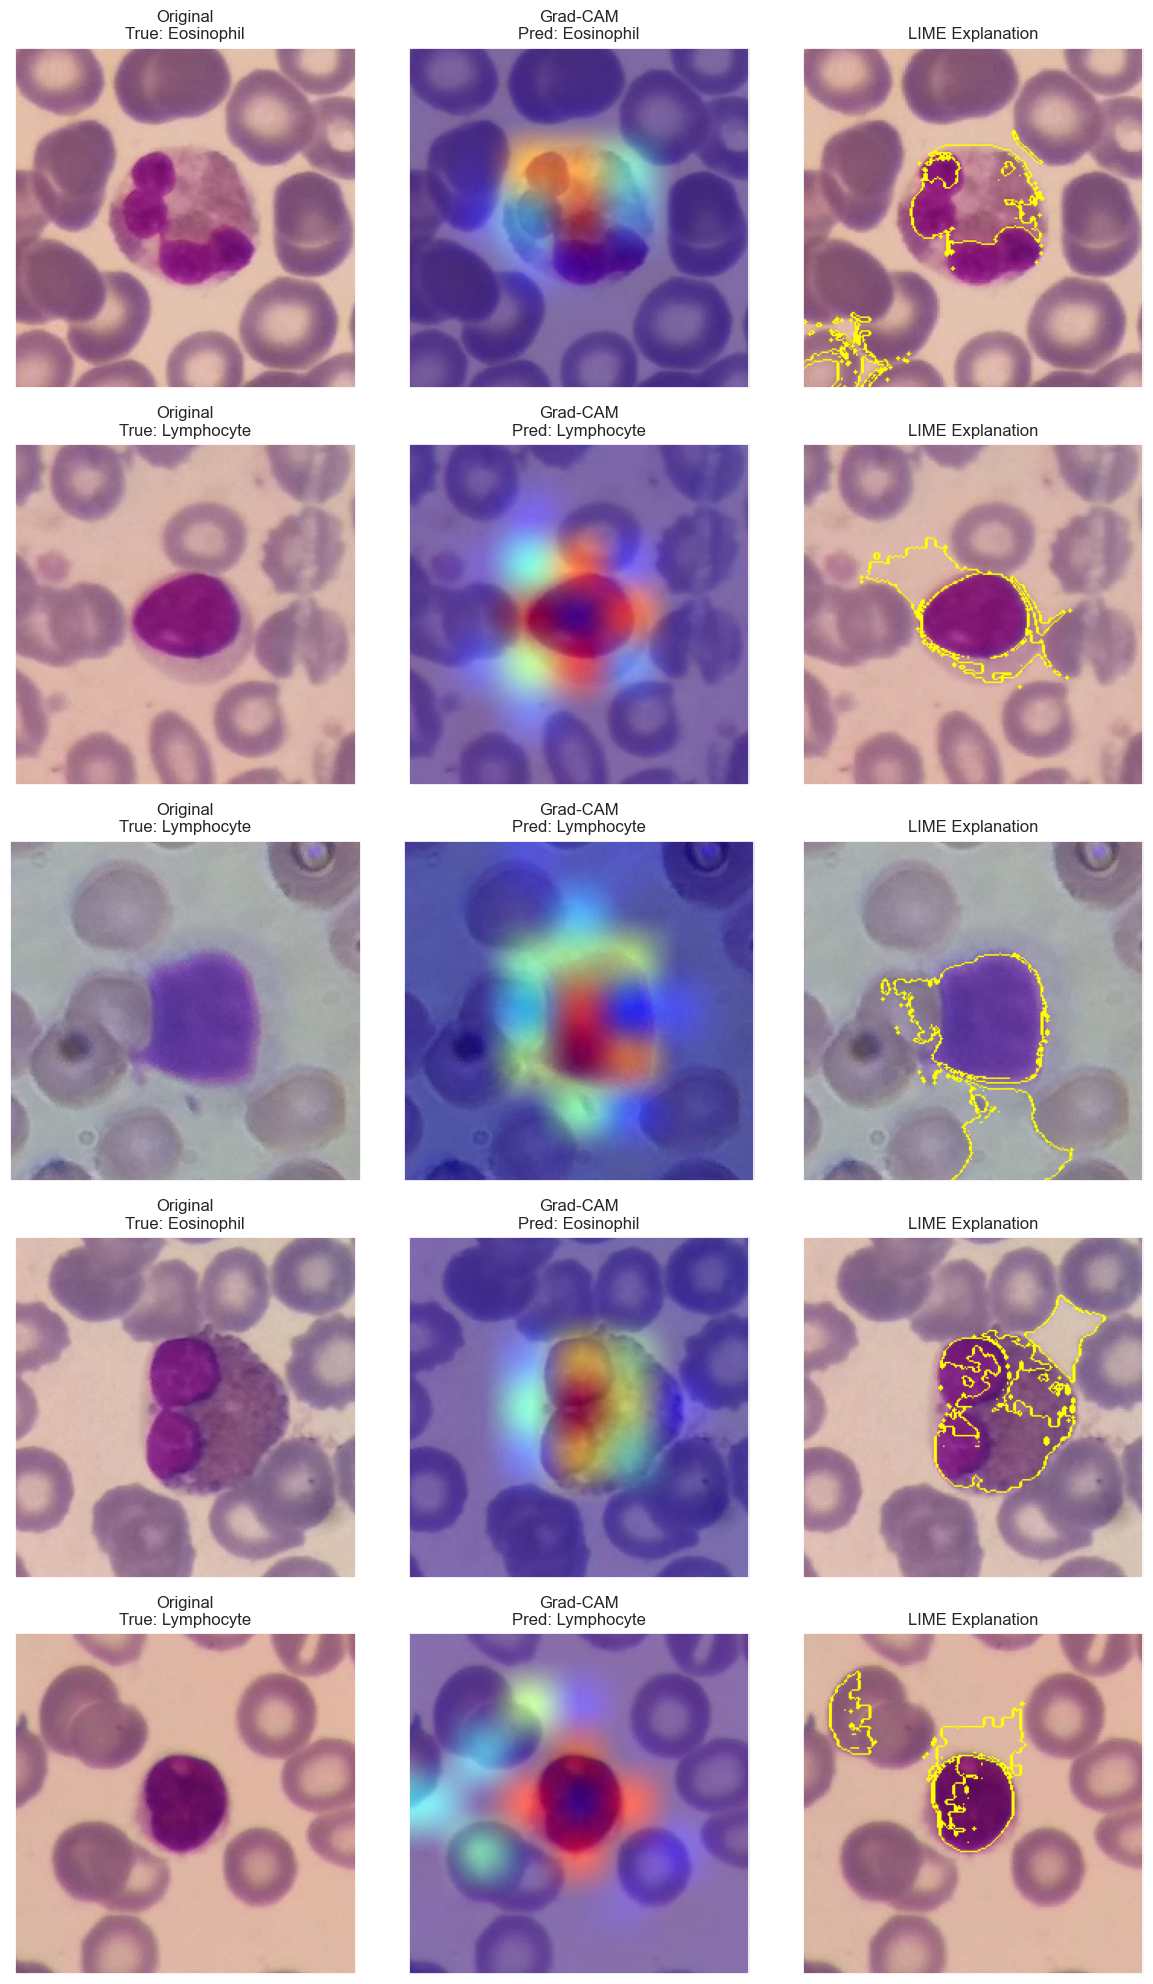

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from matplotlib import cm
from lime import lime_image
from skimage.segmentation import mark_boundaries

# --------------------------
# IMAGE PREP & GRAD-CAM
# --------------------------
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size[:2])
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)  # add batch dimension
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.9):
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)

    return cam_path

# --------------------------
# LIME EXPLAINER
# --------------------------
def lime_explanation(img_path, model, preprocess_input, top_labels=1, num_samples=1000):
    explainer = lime_image.LimeImageExplainer()

    def predict_fn(images):
        images = np.array([preprocess_input(img) for img in images])
        return model.predict(images)

    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img).astype(np.double)

    explanation = explainer.explain_instance(
        img,
        predict_fn,
        top_labels=top_labels,
        hide_color=0,
        num_samples=num_samples
    )

    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    lime_img = mark_boundaries(temp / 255.0, mask)
    return lime_img

# --------------------------
# RUN BOTH METHODS
# --------------------------
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
last_conv_layer_name = "top_conv"
img_size = (224, 224, 3)

# remove softmax for Grad-CAM
model.layers[-1].activation = None  

n_samples = 5  # number of test images to show
fig, axes = plt.subplots(nrows=n_samples, ncols=3, figsize=(12, 4 * n_samples),
                         subplot_kw={'xticks': [], 'yticks': []})

for row in range(n_samples):
    img_path = test_df.Filepath.iloc[random_index[row]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))

    # Original image
    orig_img = plt.imread(img_path)

    # Grad-CAM
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap, cam_path=f"cam_{row}.jpg")
    grad_img = plt.imread(cam_path)

    # LIME
    lime_img = lime_explanation(img_path, model, preprocess_input)

    # Plot row: Original | Grad-CAM | LIME
    axes[row, 0].imshow(orig_img.astype(np.uint8))
    axes[row, 0].set_title(f"Original\nTrue: {test_df.Label.iloc[random_index[row]]}")

    axes[row, 1].imshow(grad_img.astype(np.uint8))
    axes[row, 1].set_title(f"Grad-CAM\nPred: {pred[random_index[row]]}")

    axes[row, 2].imshow(lime_img)
    axes[row, 2].set_title("LIME Explanation")

# plt.tight_layout()
# plt.show()
plt.tight_layout()

# Save results to file
plt.savefig("gradcam_lime_results.png", dpi=300)

# Force display in notebooks
# plt.show()

